In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from internal.utils import temporal_split
from internal import run_eda_pipeline, run_preprocessing_pipeline, run_training_pipeline, run_inference_pipeline

In [25]:
import os

In [26]:
# Cargar datos de Olist Forecasting
print("📊 CARGANDO DATOS DE OLIST FORECASTING")

# Cargar datasets de forecasting
olist_forecasting_dataset = pd.read_csv('olist_forecasting_dataset_monthly.csv')
olist_forecasting_test = pd.read_csv('olist_forecasting_test.csv')
olist_forecasting_train = pd.read_csv('olist_forecasting_train_monthly.csv')

print(f"📋 Forecasting Dataset: {olist_forecasting_dataset.shape}")
print(f"📋 Forecasting Test: {olist_forecasting_test.shape}")
print(f"📋 Forecasting Train: {olist_forecasting_train.shape}")

print(f"✅ Datos de forecasting cargados exitosamente")

# Mostrar primeras filas para revisar estructura
print("\n🔍 Estructura del dataset principal:")
print(olist_forecasting_dataset.head())
print(f"\nColumnas disponibles: {list(olist_forecasting_dataset.columns)}")

📊 CARGANDO DATOS DE OLIST FORECASTING
📋 Forecasting Dataset: (16068, 55)
📋 Forecasting Test: (4613, 55)
📋 Forecasting Train: (13569, 55)
✅ Datos de forecasting cargados exitosamente

🔍 Estructura del dataset principal:
                          seller_id year_month  pedidos  ingresos_total  \
0  0015a82c2db000af6aaaf3ae2ecb0532    2017-09        1           895.0   
1  0015a82c2db000af6aaaf3ae2ecb0532    2017-10        2          1790.0   
2  001cca7ae9ae17fb1caed9dfb1094831    2017-02       11          1098.9   
3  001cca7ae9ae17fb1caed9dfb1094831    2017-03       17          1676.7   
4  001cca7ae9ae17fb1caed9dfb1094831    2017-04       15          1708.2   

   precio_promedio  envio_total  envio_promedio  pago_total  pago_promedio  \
0          895.000        21.02          21.020      916.02        916.020   
1          895.000        42.04          21.020     1832.04        916.020   
2           99.900       196.50          17.864     4075.00        370.455   
3           98.629

In [49]:
def agg_monthly(df:pd.DataFrame, ids_col, date_col, label_col) -> pd.DataFrame:

    df_monthly = df.copy()
    df_monthly[date_col] = pd.to_datetime(df_monthly[date_col])
    df_monthly['year_month'] = df_monthly[date_col].dt.to_period('M')

    # Agrupar por seller_id y mes, sumando los pedidos
    monthly_summary = df_monthly.groupby([ids_col, 'year_month'])[label_col].sum().reset_index()
    monthly_summary['year_month'] = monthly_summary['year_month'].dt.to_timestamp()

    return monthly_summary.sort_values(by = [ids_col, 'year_month'])

In [51]:
data = olist_forecasting_dataset
frequency = 'W-MON'

ids_col = 'seller_id'
date_col ='year_month'

label_col = 'pedidos'
HORIZON = 4
df = data[[ids_col, date_col, label_col]]
df_cov = data[[ids_col, date_col,'ingresos_total']]

In [54]:
df_cov


,seller_id,year_month,ingresos_total
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09,895.0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10,1790.0
2,001cca7ae9ae17fb1caed9dfb1094831,2017-02,1098.9
3,001cca7ae9ae17fb1caed9dfb1094831,2017-03,1676.7
4,001cca7ae9ae17fb1caed9dfb1094831,2017-04,1708.2
...,...,...,...
16063,fffd5413c0700ac820c7069d66d98c89,2018-06,248.3
16064,fffd5413c0700ac820c7069d66d98c89,2018-07,286.0
16065,fffd5413c0700ac820c7069d66d98c89,2018-08,485.4
16066,ffff564a4f9085cd26170f4732393726,2016-10,120.5


In [55]:
df = agg_monthly(df, ids_col, date_col, label_col)
df_cov = agg_monthly(df_cov, ids_col, date_col, 'ingresos_total')

In [56]:
df[date_col] = pd.to_datetime(df[date_col])
df_cov[date_col] = pd.to_datetime(df_cov[date_col])

In [57]:
df_train, df_evaluate = temporal_split(df, horizon=HORIZON, ids_col=ids_col)
df_covariates_train, df_covariates_evaluate = temporal_split(df_cov, horizon=HORIZON, ids_col=ids_col)

# EDA

In [58]:
eda_results = run_eda_pipeline(df=df,
                                df_covariates= df_cov,
                                label_col= label_col, 
                                date_col= date_col, 
                                ids_col= ids_col,
                                frequency= frequency
                                
    )

In [59]:
print(f'La informacion que presenta la EDA es : {eda_results.keys()}')

La informacion que presenta la EDA es : dict_keys(['basic_info', 'number_of_observations', 'missing_dates', 'missing_data', 'stationarity_test'])


# Preprocessing

In [60]:
df[df[ids_col] == '010da0602d7774602cd1b3f5fb7b709e']

,seller_id,year_month,pedidos
75,010da0602d7774602cd1b3f5fb7b709e,2018-06-01,5


In [61]:
df_processed, df_covariates_processed, preprocessing_objects = run_preprocessing_pipeline(df_train, 
                                                                   df_covariates= df_covariates_train,
                                                                   label_col =  label_col ,
                                                                   date_col = date_col, 
                                                                   ids_col = ids_col, 
                                                                   missing_data_method = 'bfill',
                                                                   frequency = frequency,
                                                                   scaler = 'standard',
                                                                   horizon = HORIZON, 
                                                                   minimum_length = 12
                                         
    )
    


# Training

In [62]:
champion_model, test_metrics, test_predictions = run_training_pipeline(df_processed,
                                                        df_covariates = df_covariates_processed,
                                                        label_col = label_col, 
                                                        date_col = date_col, 
                                                        ids_col = ids_col,
                                                        # models = {'LightGBM': {'window_size': [HORIZON, 3*HORIZON]},
                                                        #         'LinearRegression': {'window_size': [HORIZON, 2*HORIZON]}}, 
                                                        models = {
                                                            # Modelos de Machine Learning optimizados
                                                            'LightGBM': {'window_size': [HORIZON, 2*HORIZON], 'differencing': True},
                                                            'XGBoost': {'window_size': [HORIZON, 2*HORIZON], 'differencing': True},
                                                            'RandomForest': {'window_size': [HORIZON, 2*HORIZON], 'differencing': True},
                                                            # 'ExtraTrees': {'window_size': [HORIZON, 2*HORIZON]},
                                                            'DecisionTrees': {'window_size': [HORIZON, 2*HORIZON], 'differencing': True},
                                                            #'LinearRegression': {'window_size': [HORIZON, 2*HORIZON]},
                                                        },
                                                        n_splits = 1, 
                                                        horizon = HORIZON, 
                                                        metric = 'mape',
                                                        use_best_params = True,
                                                        refit_model = True 
    )

Best trial: 0. Best value: 0: 100%|██████████| 60/60 [02:30<00:00,  2.51s/it]


# Inference

In [63]:
df_covariates_evaluate = df_covariates_evaluate[df_covariates_evaluate[ids_col].isin(df_covariates_processed[ids_col].unique())]
df_evaluate = df_evaluate[df_evaluate[ids_col].isin(df_covariates_processed[ids_col].unique())]

In [65]:
predictions = run_inference_pipeline(preprocessing_objects,
                                    champion_model, 
                                    horizon = HORIZON,
                                    df_future_covariates=df_covariates_evaluate
                                    
)

ValueError: Found missing inputs in X_df. It should have one row per id and time for the complete forecasting horizon.
You can get the expected structure by running `MLForecast.make_future_dataframe(h)` or get the missing combinatins in your current `X_df` by running `MLForecast.get_missing_future(h, X_df)`.

In [ ]:
predictions

,seller_id,year_month,predictions
0,001cca7ae9ae17fb1caed9dfb1094831,2018-05-01,41.234625
1,001cca7ae9ae17fb1caed9dfb1094831,2018-06-01,43.375188
2,001cca7ae9ae17fb1caed9dfb1094831,2018-07-01,37.369721
3,001cca7ae9ae17fb1caed9dfb1094831,2018-08-01,36.358900
4,004c9cd9d87a3c30c522c48c4fc07416,2018-05-01,32.388231
...,...,...,...
2187,ff063b022a9a0aab91bad2c9088760b7,2018-08-01,55.591120
2188,ffdd9f82b9a447f6f8d4b91554cc7dd3,2018-05-01,3.146053
2189,ffdd9f82b9a447f6f8d4b91554cc7dd3,2018-06-01,3.124251
2190,ffdd9f82b9a447f6f8d4b91554cc7dd3,2018-07-01,3.494290


In [ ]:
# Cargar datos reales que se usaron para train y test
datos_reales =df.copy()
datos_reales = datos_reales[datos_reales[date_col] >= '2018-05-01']
datos_reales = datos_reales[datos_reales[date_col] <= '2018-08-01']

print(f"📊 Datos reales para evaluación: {datos_reales.shape}")
print(f"Período: {datos_reales[date_col].min()} a {datos_reales[date_col].max()}")
print("\n🔍 Primeras filas de datos reales:")
print(datos_reales.head())

📊 Datos reales para evaluación: (4769, 3)
Período: 2018-05-01 00:00:00 a 2018-08-01 00:00:00

🔍 Primeras filas de datos reales:
                           seller_id year_month  pedidos
17  001cca7ae9ae17fb1caed9dfb1094831 2018-06-01        2
18  001cca7ae9ae17fb1caed9dfb1094831 2018-07-01        1
44  004c9cd9d87a3c30c522c48c4fc07416 2018-05-01        2
49  00720abe85ba0859807595bbf045a33b 2018-05-01        5
50  00720abe85ba0859807595bbf045a33b 2018-06-01        6


In [ ]:
df_processed

,year_month,seller_id,pedidos
0,2017-02-01,001cca7ae9ae17fb1caed9dfb1094831,-1.398790
1,2017-03-01,001cca7ae9ae17fb1caed9dfb1094831,-0.325300
2,2017-04-01,001cca7ae9ae17fb1caed9dfb1094831,-0.683130
3,2017-05-01,001cca7ae9ae17fb1caed9dfb1094831,1.284935
4,2017-06-01,001cca7ae9ae17fb1caed9dfb1094831,0.569275
...,...,...,...
8243,2017-12-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,1.463850
8244,2018-01-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,1.463850
8245,2018-02-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,1.463850
8246,2018-03-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,1.463850


In [ ]:
df_processed.dtypes

year_month    datetime64[ns]
seller_id             object
pedidos              float64
dtype: object

📊 Creando comparación completa de todos los modelos...
🔄 Reescalando predicciones de 4 modelos...
🏆 Modelo campeón: RandomForest

📋 INFORMACIÓN DE LOS DATASETS:
Datos Reales Completos - Período: 2016-10 a 2018-04
Datos Reales Completos - Total de meses: 19
  └─ Train: 2016-10 a 2017-12 (15 meses)
  └─ Test: 2018-01 a 2018-04 (4 meses)
Predicciones de Modelos - Período de validación: 4 modelos comparados
🔮 Agregando predicciones futuras (tabla predictions)...

📊 ESTADÍSTICAS COMPARATIVAS:
Datos Reales - Train: 48,680 pedidos/mes promedio
Datos Reales - Test: 79,266 pedidos/mes promedio

🤖 PREDICCIONES DE MODELOS (promedio mensual en período de test):
  LightGBM: 99,641 pedidos
  XGBoost: 83,707 pedidos
  RandomForest: 89,829 pedidos 🏆
  DecisionTrees: 101,152 pedidos

🔮 PREDICCIONES FUTURAS (promedio mensual):
  Predicciones Futuras: 59,745 pedidos/mes
  Período: 2018-05 a 2018-08
  Total meses predichos: 4

🎯 MÉTRICAS DE PRECISIÓN POR MODELO:
  LightGBM:
    MAE: 20,375 pedidos
    MAP

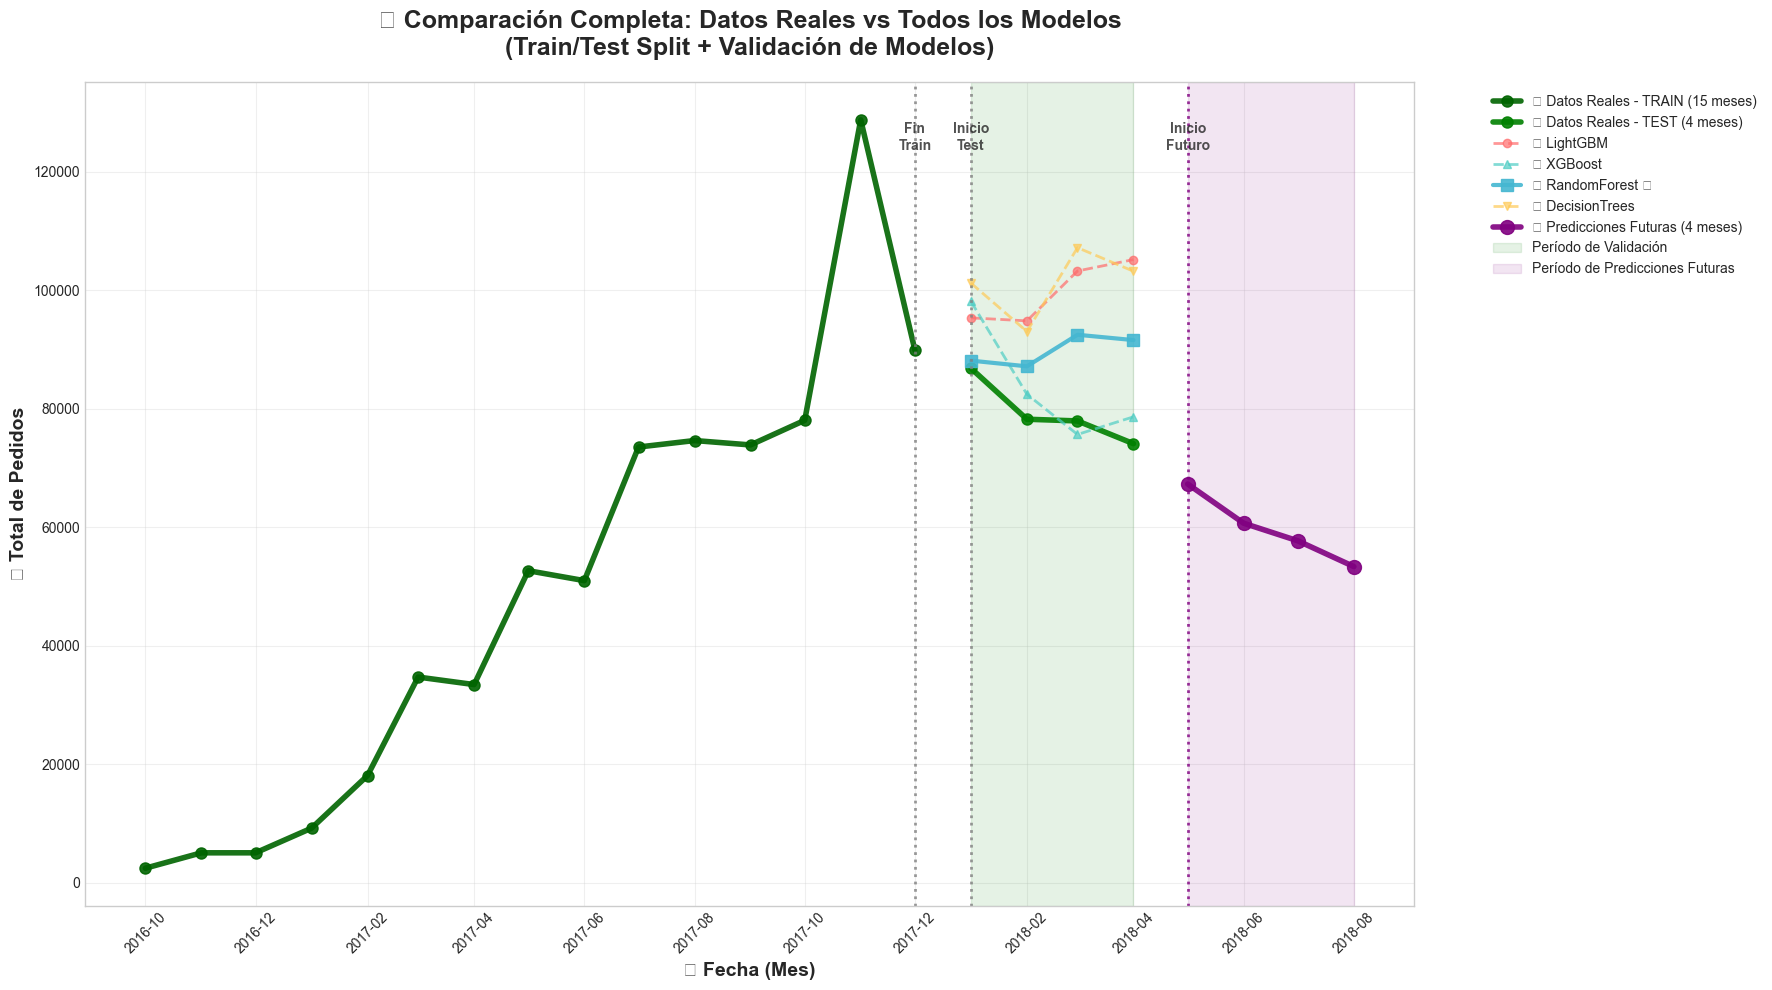

✅ Gráfico comparativo completado


In [ ]:
# Comparación Completa: Datos Reales vs Todos los Modelos en Validación
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("📊 Creando comparación completa de todos los modelos...")
scaler = preprocessing_objects['scaler']
df_processed[label_col] = scaler.inverse_transform(df_processed[['seller_id', label_col]], predictions_col = label_col)[label_col]
# 1. Preparar TODOS los datos reales para ver la partición train/test
all_real_data_monthly = df_processed.groupby(date_col)[label_col].sum().reset_index()
all_real_data_monthly = all_real_data_monthly.sort_values(date_col)

# 2. Definir fechas de partición train/test
train_end_date = pd.to_datetime('2017-12-01')  # Último mes de entrenamiento
test_start_date = pd.to_datetime('2018-01-01')  # Primer mes de test

# 3. Separar datos reales en train y test
real_train_monthly = all_real_data_monthly[all_real_data_monthly[date_col] <= train_end_date].copy()
real_test_monthly = all_real_data_monthly[all_real_data_monthly[date_col] >= test_start_date].copy()

# 4. Preparar predicciones de TODOS los modelos (reescaladas)
# model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'ExtraTrees', 'DecisionTrees', 'LinearRegression']
model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'DecisionTrees']
#model_names = ['LinearRegression']
model_predictions_monthly = {}

scaler = preprocessing_objects['scaler']

print(f"🔄 Reescalando predicciones de {len(model_names)} modelos...")
for model_name in model_names:
    # Crear copia de test_predictions con la columna del modelo actual
    temp_predictions = test_predictions.copy()
    temp_predictions['predictions'] = temp_predictions[model_name]
    
    # Reescalar usando solo las columnas necesarias
    temp_unscaled = scaler.inverse_transform(temp_predictions[['seller_id', 'year_month', 'predictions']])
    
    # Agregar por mes
    model_monthly = temp_unscaled.groupby(date_col)['predictions'].sum().reset_index()
    model_monthly = model_monthly.sort_values(date_col)
    model_predictions_monthly[model_name] = model_monthly

# 5. Identificar modelo campeón
champion_model_name = type(champion_model).__name__.replace('Model', '')
print(f"🏆 Modelo campeón: {champion_model_name}")

# 6. Mostrar información de los datasets
print(f"\n📋 INFORMACIÓN DE LOS DATASETS:")
print(f"Datos Reales Completos - Período: {all_real_data_monthly[date_col].min().strftime('%Y-%m')} a {all_real_data_monthly[date_col].max().strftime('%Y-%m')}")
print(f"Datos Reales Completos - Total de meses: {len(all_real_data_monthly)}")
print(f"  └─ Train: {real_train_monthly[date_col].min().strftime('%Y-%m')} a {real_train_monthly[date_col].max().strftime('%Y-%m')} ({len(real_train_monthly)} meses)")
print(f"  └─ Test: {real_test_monthly[date_col].min().strftime('%Y-%m')} a {real_test_monthly[date_col].max().strftime('%Y-%m')} ({len(real_test_monthly)} meses)")
print(f"Predicciones de Modelos - Período de validación: {len(model_names)} modelos comparados")

# 7. Crear el gráfico
plt.figure(figsize=(18, 10))

# Definir colores y estilos para cada modelo
model_colors = {
    'LightGBM': '#FF6B6B',      # Rojo claro
    'XGBoost': '#4ECDC4',       # Turquesa
    'RandomForest': '#45B7D1',  # Azul
    'ExtraTrees': '#96CEB4',    # Verde claro
    'DecisionTrees': '#FECA57', # Amarillo
    'LinearRegression': '#FF9FF3' # Rosa
}

model_markers = {
    'LightGBM': 'o',
    'XGBoost': '^', 
    'RandomForest': 's',
    'ExtraTrees': 'D',
    'DecisionTrees': 'v',
    'LinearRegression': 'p'
}

# Plot datos reales - TRAIN (línea continua gruesa)
plt.plot(real_train_monthly[date_col], real_train_monthly[label_col], 
         'o-', color='darkgreen', linewidth=4, markersize=8, 
         label=f'📊 Datos Reales - TRAIN ({len(real_train_monthly)} meses)', alpha=0.9)

# Plot datos reales - TEST (línea continua gruesa)
plt.plot(real_test_monthly[date_col], real_test_monthly[label_col], 
         'o-', color='green', linewidth=4, markersize=8, 
         label=f'✅ Datos Reales - TEST ({len(real_test_monthly)} meses)', alpha=0.9)

# Plot predicciones de TODOS los modelos
for model_name in model_names:
    model_data = model_predictions_monthly[model_name]
    linestyle = '-' if model_name == champion_model_name else '--'
    linewidth = 3 if model_name == champion_model_name else 2
    alpha = 0.9 if model_name == champion_model_name else 0.7
    marker_size = 8 if model_name == champion_model_name else 6
    
    label_suffix = " 🏆" if model_name == champion_model_name else ""
    
    plt.plot(model_data[date_col], model_data['predictions'], 
             marker=model_markers[model_name], linestyle=linestyle, 
             color=model_colors[model_name], linewidth=linewidth, 
             markersize=marker_size, alpha=alpha,
             label=f'🤖 {model_name}{label_suffix}')

# 🔮 Agregar predicciones futuras de la tabla 'predictions' 
print("🔮 Agregando predicciones futuras (tabla predictions)...")
future_predictions_monthly = predictions.groupby(date_col)['predictions'].sum().reset_index()
future_predictions_monthly = future_predictions_monthly.sort_values(date_col)

plt.plot(future_predictions_monthly[date_col], future_predictions_monthly['predictions'], 
         'o-', color='purple', linewidth=4, markersize=10, alpha=0.9,
         label=f'🔮 Predicciones Futuras ({len(future_predictions_monthly)} meses)')

# Línea vertical para separar train/test
plt.axvline(x=train_end_date, color='gray', linestyle=':', alpha=0.8, linewidth=2)
plt.axvline(x=test_start_date, color='gray', linestyle=':', alpha=0.8, linewidth=2)

# Línea vertical para separar test/future
future_start_date = future_predictions_monthly[date_col].min()
plt.axvline(x=future_start_date, color='purple', linestyle=':', alpha=0.8, linewidth=2)

# 6. Configuración del gráfico
plt.title('📈 Comparación de Pedidos Totales por Mes\n(Datos Reales vs Test Predictions vs Future Predictions)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('📅 Fecha (Mes)', fontsize=12, fontweight='bold')
plt.ylabel('📦 Total de Pedidos', fontsize=12, fontweight='bold')

# Formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Configuraciones adicionales
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# Configuración del gráfico
plt.title('📈 Comparación Completa: Datos Reales vs Todos los Modelos\n(Train/Test Split + Validación de Modelos)', 
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('📅 Fecha (Mes)', fontsize=14, fontweight='bold')
plt.ylabel('📦 Total de Pedidos', fontsize=14, fontweight='bold')

# Formato de fechas en el eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

# Añadir texto explicativo
plt.text(train_end_date, plt.ylim()[1]*0.95, 'Fin\nTrain', 
         ha='center', va='top', fontsize=10, alpha=0.8, fontweight='bold')
plt.text(test_start_date, plt.ylim()[1]*0.95, 'Inicio\nTest', 
         ha='center', va='top', fontsize=10, alpha=0.8, fontweight='bold')
plt.text(future_start_date, plt.ylim()[1]*0.95, 'Inicio\nFuturo', 
         ha='center', va='top', fontsize=10, alpha=0.8, fontweight='bold')

# Añadir área sombreada para período de test
plt.axvspan(test_start_date, real_test_monthly[date_col].max(), 
            alpha=0.1, color='green', label='Período de Validación')

# Añadir área sombreada para período de predicciones futuras
plt.axvspan(future_start_date, future_predictions_monthly[date_col].max(), 
            alpha=0.1, color='purple', label='Período de Predicciones Futuras')

# Configuraciones adicionales
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# 9. Estadísticas comparativas
print(f"\n📊 ESTADÍSTICAS COMPARATIVAS:")
print(f"Datos Reales - Train: {real_train_monthly[label_col].mean():,.0f} pedidos/mes promedio")
print(f"Datos Reales - Test: {real_test_monthly[label_col].mean():,.0f} pedidos/mes promedio")

print(f"\n🤖 PREDICCIONES DE MODELOS (promedio mensual en período de test):")
for model_name in model_names:
    model_avg = model_predictions_monthly[model_name]['predictions'].mean()
    champion_marker = " 🏆" if model_name == champion_model_name else ""
    print(f"  {model_name}: {model_avg:,.0f} pedidos{champion_marker}")

print(f"\n🔮 PREDICCIONES FUTURAS (promedio mensual):")
future_avg = future_predictions_monthly['predictions'].mean()
print(f"  Predicciones Futuras: {future_avg:,.0f} pedidos/mes")
print(f"  Período: {future_predictions_monthly[date_col].min().strftime('%Y-%m')} a {future_predictions_monthly[date_col].max().strftime('%Y-%m')}")
print(f"  Total meses predichos: {len(future_predictions_monthly)}")

# 10. Calcular métricas de error para TODOS los modelos
print(f"\n🎯 MÉTRICAS DE PRECISIÓN POR MODELO:")
model_metrics = {}

for model_name in model_names:
    # Merge datos reales del test con predicciones del modelo
    comparison = pd.merge(real_test_monthly, model_predictions_monthly[model_name], on=date_col, how='inner')
    
    if len(comparison) > 0:
        mae = abs(comparison[label_col] - comparison['predictions']).mean()
        mape = (abs(comparison[label_col] - comparison['predictions']) / comparison[label_col] * 100).mean()
        rmse = np.sqrt(((comparison[label_col] - comparison['predictions']) ** 2).mean())
        
        model_metrics[model_name] = {'MAE': mae, 'MAPE': mape, 'RMSE': rmse}
        
        champion_marker = " 🏆" if model_name == champion_model_name else ""
        print(f"  {model_name}{champion_marker}:")
        print(f"    MAE: {mae:,.0f} pedidos")
        print(f"    MAPE: {mape:.1f}%")
        print(f"    RMSE: {rmse:,.0f} pedidos")

# 11. Crear tabla de ranking de modelos por MAPE
print(f"\n🏆 RANKING DE MODELOS (ordenado por MAPE):")
ranking = sorted(model_metrics.items(), key=lambda x: x[1]['MAPE'])
for i, (model_name, metrics) in enumerate(ranking, 1):
    champion_marker = " 🏆" if model_name == champion_model_name else ""
    print(f"  {i}. {model_name}{champion_marker}: {metrics['MAPE']:.1f}% MAPE")

# 12. Crear tabla de ranking de modelos por MAE
print(f"\n🏅 RANKING DE MODELOS (ordenado por MAE):")
ranking_mae = sorted(model_metrics.items(), key=lambda x: x[1]['MAE'])
for i, (model_name, metrics) in enumerate(ranking_mae, 1):
    champion_marker = " 🏆" if model_name == champion_model_name else ""
    print(f"  {i}. {model_name}{champion_marker}: {metrics['MAE']:.0f} MAE")

plt.show()
plt.show()
print("✅ Gráfico comparativo completado")

In [ ]:
# Verificar estructura de test_predictions
print("🔍 Verificando estructura de test_predictions:")
print(f"Columnas en test_predictions: {list(test_predictions.columns)}")
print(f"Shape: {test_predictions.shape}")
print("\nPrimeras filas:")
print(test_predictions.head())

🔍 Verificando estructura de test_predictions:
Columnas en test_predictions: ['year_month', 'seller_id', 'pedidos', 'LightGBM', 'XGBoost', 'RandomForest', 'DecisionTrees']
Shape: (2192, 7)

Primeras filas:
  year_month                         seller_id  pedidos   LightGBM    XGBoost  \
0 2018-01-01  001cca7ae9ae17fb1caed9dfb1094831      8.0   6.758518   5.462387   
1 2018-02-01  001cca7ae9ae17fb1caed9dfb1094831      3.0   4.078308   3.940234   
2 2018-03-01  001cca7ae9ae17fb1caed9dfb1094831      3.0   3.806151   1.723606   
3 2018-04-01  001cca7ae9ae17fb1caed9dfb1094831      3.0   3.389872   0.974429   
4 2018-01-01  004c9cd9d87a3c30c522c48c4fc07416      8.0  13.911042  12.239896   

   RandomForest  DecisionTrees  
0      7.000000            4.0  
1      5.500000           14.0  
2      4.393617            7.0  
3      4.191489           11.0  
4     11.989362           22.0  


📈 GENERANDO ANÁLISIS VISUAL COMPLETO PARA DOCUMENTO...
✅ Datos preparados exitosamente
   📊 Datos históricos: 19
   🎯 Modelo campeón: RandomForest
   📈 Modelos comparados: 4

📋 RESUMEN EJECUTIVO DEL ANÁLISIS DE FORECASTING
🎯 OBJETIVO: Predicción de demanda mensual de pedidos Olist
📅 PERÍODO ANALIZADO: October 2016 - April 2018
🔬 MODELOS EVALUADOS: 4 algoritmos de Machine Learning
🏆 MODELO CAMPEÓN: RandomForest (MAPE: 13.8%)

📊 RESULTADOS PRINCIPALES:
----------------------------------------
  • Precisión del modelo campeón: 86.2% de exactitud
  • Tendencia identificada: Decrecimiento
  • Predicción promedio futura: 59,745 pedidos/mes
  • Variación vs período actual: -24.6%

🎖️ RANKING DE MODELOS:
-----------------------------------
  🥇 1. XGBoost: 6.9% MAPE
  🥈 2. RandomForest: 13.8% MAPE
  🥉 3. LightGBM: 26.4% MAPE
     4. DecisionTrees: 28.1% MAPE


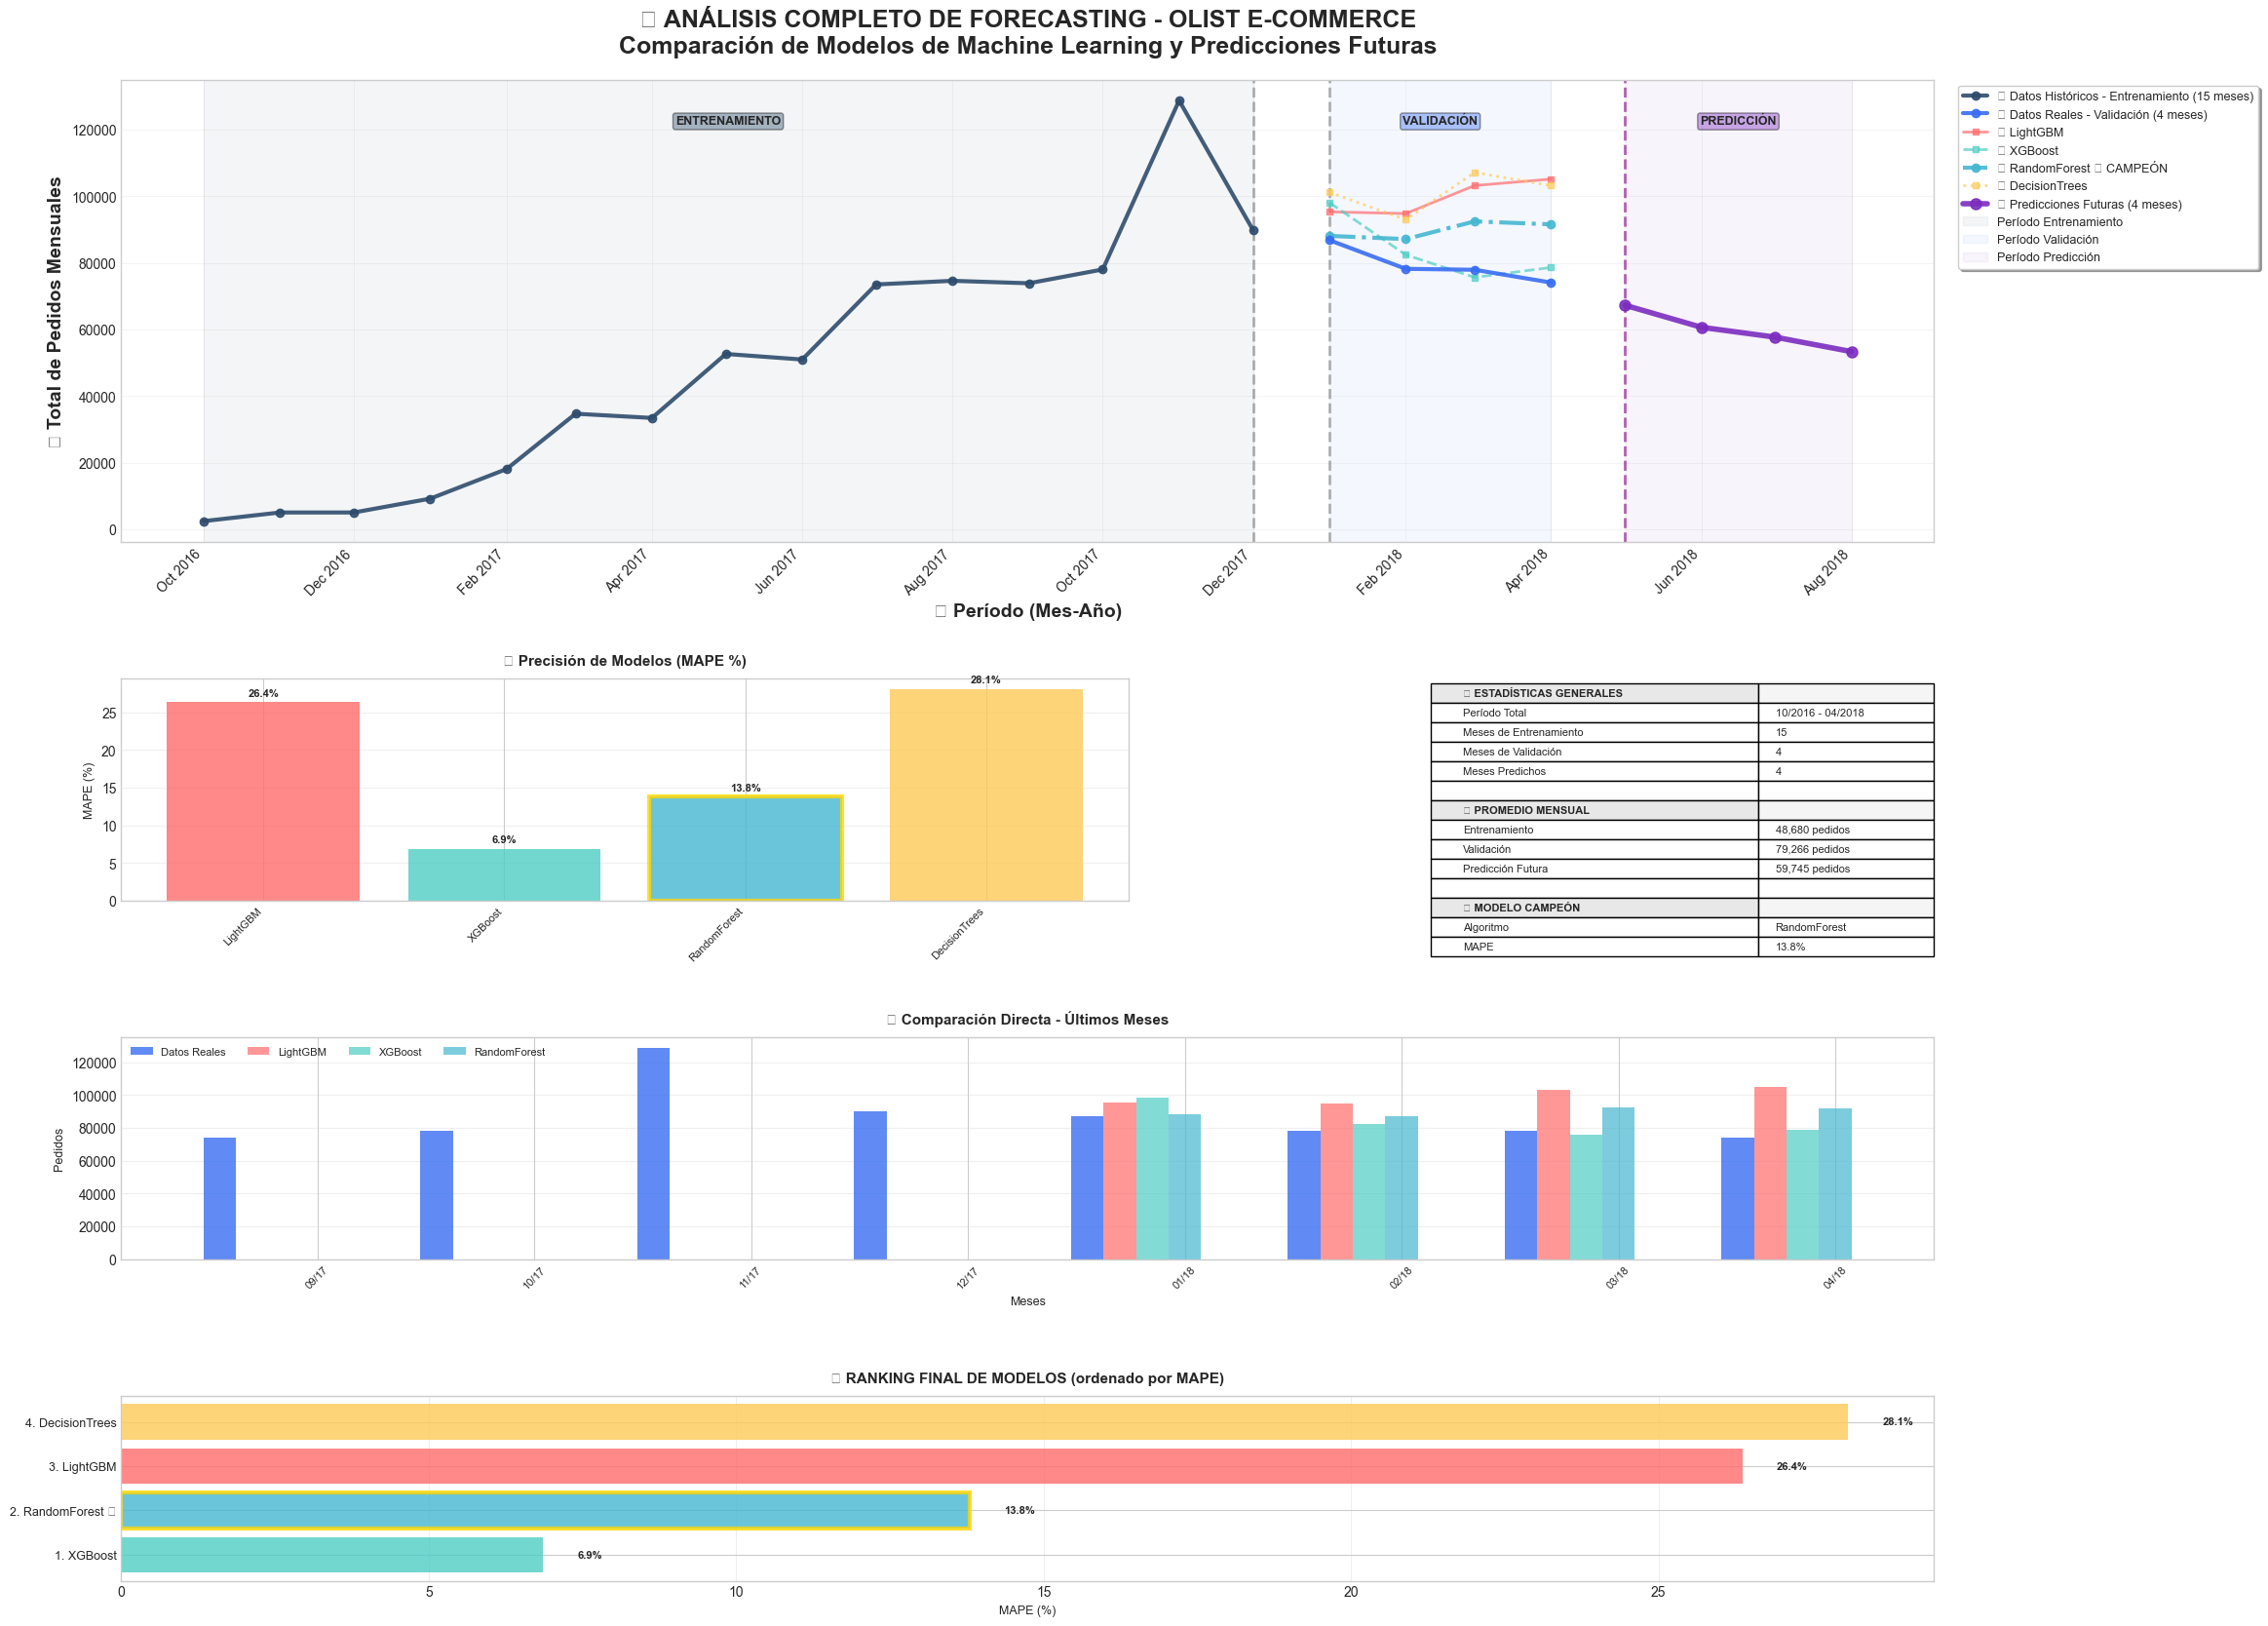


✅ ANÁLISIS VISUAL COMPLETO GENERADO EXITOSAMENTE
📄 Dashboard profesional listo para documento de análisis
🎯 5 secciones organizadas con separación visual clara
📊 Métricas de rendimiento y comparación de modelos


In [ ]:
# 📊 ANÁLISIS COMPLETO DE FORECASTING - VISUALIZACIÓN PROFESIONAL
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo profesional
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("📈 GENERANDO ANÁLISIS VISUAL COMPLETO PARA DOCUMENTO...")
print("=" * 70)

# =====================================================================================
# 🔧 1. PREPARACIÓN DE DATOS PARA VISUALIZACIÓN PROFESIONAL
# =====================================================================================

# Datos reales completos
all_real_data_monthly = df_processed.groupby(date_col)[label_col].sum().reset_index()
all_real_data_monthly = all_real_data_monthly.sort_values(date_col)

# Fechas de partición
train_end_date = pd.to_datetime('2017-12-01')
test_start_date = pd.to_datetime('2018-01-01')

# Separar en train y test
real_train_monthly = all_real_data_monthly[all_real_data_monthly[date_col] <= train_end_date].copy()
real_test_monthly = all_real_data_monthly[all_real_data_monthly[date_col] >= test_start_date].copy()

# Preparar predicciones de todos los modelos
# model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'ExtraTrees', 'DecisionTrees', 'LinearRegression']
model_names = ['LightGBM', 'XGBoost', 'RandomForest', 'DecisionTrees']
model_predictions_monthly = {}

for model_name in model_names:
    temp_predictions = test_predictions.copy()
    temp_predictions['predictions'] = temp_predictions[model_name]
    temp_unscaled = scaler.inverse_transform(temp_predictions[['seller_id', 'year_month', 'predictions']])
    model_monthly = temp_unscaled.groupby(date_col)['predictions'].sum().reset_index()
    model_monthly = model_monthly.sort_values(date_col)
    model_predictions_monthly[model_name] = model_monthly

# Preparar predicciones futuras
future_predictions_monthly = predictions.groupby(date_col)['predictions'].sum().reset_index()
future_predictions_monthly = future_predictions_monthly.sort_values(date_col)

# Identificar modelo campeón
champion_model_name = type(champion_model).__name__.replace('Model', '')

print("✅ Datos preparados exitosamente")
print("   📊 Datos históricos:", len(all_real_data_monthly))
print("   🎯 Modelo campeón:", champion_model_name)
print("   📈 Modelos comparados:", len(model_names))

# =====================================================================================
# 🎨 2. CREAR FIGURA PRINCIPAL CON DISEÑO DE DASHBOARD
# =====================================================================================
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(4, 2, height_ratios=[2.5, 1.2, 1.2, 1], width_ratios=[2, 1], hspace=0.5, wspace=0.4)

# ─────────────────────────────────────────────────────────────────────────────────
# 📈 SECCIÓN 1: GRÁFICO PRINCIPAL - TIME SERIES COMPLETA
# ─────────────────────────────────────────────────────────────────────────────────
ax_main = fig.add_subplot(gs[0, :])

# Definir paleta de colores profesional
colors = {
    'train': '#2E4C6D',      # Azul oscuro profesional
    'test': '#396DF2',       # Azul medio
    'future': '#7B2CBF',     # Morado
    'LightGBM': '#FF6B6B',   # Rojo coral
    'XGBoost': '#4ECDC4',    # Turquesa
    'RandomForest': '#45B7D1', # Azul cielo
    #'ExtraTrees': '#96CEB4',  # Verde menta
    'DecisionTrees': '#FECA57', # Amarillo dorado
    #'LinearRegression': '#FF9FF3' # Rosa
}

# Plot datos reales con estilo profesional
ax_main.plot(real_train_monthly[date_col], real_train_monthly[label_col], 
            'o-', color=colors['train'], linewidth=3, markersize=6, 
            label=f'📊 Datos Históricos - Entrenamiento ({len(real_train_monthly)} meses)', 
            alpha=0.9, zorder=5)

ax_main.plot(real_test_monthly[date_col], real_test_monthly[label_col], 
            'o-', color=colors['test'], linewidth=3, markersize=6, 
            label=f'✅ Datos Reales - Validación ({len(real_test_monthly)} meses)', 
            alpha=0.9, zorder=5)

# Plot predicciones de modelos con diferentes estilos
line_styles = ['-', '--', '-.', ':', '-', '--']
for i, model_name in enumerate(model_names):
    model_data = model_predictions_monthly[model_name]
    is_champion = model_name == champion_model_name
    
    ax_main.plot(model_data[date_col], model_data['predictions'], 
                marker='o' if is_champion else 's', 
                linestyle=line_styles[i], 
                color=colors[model_name], 
                linewidth=3 if is_champion else 2, 
                markersize=6 if is_champion else 4, 
                alpha=0.9 if is_champion else 0.7,
                label=f'🤖 {model_name}' + (' 🏆 CAMPEÓN' if is_champion else ''),
                zorder=4 if is_champion else 3)

# Plot predicciones futuras
ax_main.plot(future_predictions_monthly[date_col], future_predictions_monthly['predictions'], 
            'o-', color=colors['future'], linewidth=4, markersize=8, alpha=0.9,
            label=f'🔮 Predicciones Futuras ({len(future_predictions_monthly)} meses)',
            zorder=6)

# Áreas sombreadas para delimitar períodos
ax_main.axvspan(real_train_monthly[date_col].min(), train_end_date, 
               alpha=0.05, color=colors['train'], label='Período Entrenamiento')
ax_main.axvspan(test_start_date, real_test_monthly[date_col].max(), 
               alpha=0.05, color=colors['test'], label='Período Validación')
ax_main.axvspan(future_predictions_monthly[date_col].min(), future_predictions_monthly[date_col].max(), 
               alpha=0.05, color=colors['future'], label='Período Predicción')

# Líneas verticales separadoras
ax_main.axvline(x=train_end_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)
ax_main.axvline(x=test_start_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)
ax_main.axvline(x=future_predictions_monthly[date_col].min(), color='purple', linestyle='--', alpha=0.6, linewidth=2)

# Configuración del gráfico principal
ax_main.set_title('📈 ANÁLISIS COMPLETO DE FORECASTING - OLIST E-COMMERCE\n' + 
                 'Comparación de Modelos de Machine Learning y Predicciones Futuras', 
                 fontsize=18, fontweight='bold', pad=20)
ax_main.set_xlabel('📅 Período (Mes-Año)', fontsize=14, fontweight='bold')
ax_main.set_ylabel('📦 Total de Pedidos Mensuales', fontsize=14, fontweight='bold')

# Formato de fechas mejorado
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_main.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.setp(ax_main.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Grid y leyenda mejorados
ax_main.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
ax_main.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9, frameon=True, shadow=True)

# Añadir anotaciones de períodos (más separadas)
y_pos = ax_main.get_ylim()[1] * 0.92
ax_main.annotate('ENTRENAMIENTO', xy=(real_train_monthly[date_col].mean(), y_pos), 
                ha='center', va='top', fontsize=9, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor=colors['train'], alpha=0.4))
ax_main.annotate('VALIDACIÓN', xy=(real_test_monthly[date_col].mean(), y_pos), 
                ha='center', va='top', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor=colors['test'], alpha=0.4))
ax_main.annotate('PREDICCIÓN', xy=(future_predictions_monthly[date_col].mean(), y_pos), 
                ha='center', va='top', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor=colors['future'], alpha=0.4))

# ─────────────────────────────────────────────────────────────────────────────────
# 🎯 SECCIÓN 2: MÉTRICAS DE PRECISIÓN POR MODELO
# ─────────────────────────────────────────────────────────────────────────────────
ax_metrics = fig.add_subplot(gs[1, 0])

# Calcular métricas para todos los modelos
model_metrics = {}
for model_name in model_names:
    comparison = pd.merge(real_test_monthly, model_predictions_monthly[model_name], on=date_col, how='inner')
    if len(comparison) > 0:
        mae = abs(comparison[label_col] - comparison['predictions']).mean()
        mape = (abs(comparison[label_col] - comparison['predictions']) / comparison[label_col] * 100).mean()
        rmse = np.sqrt(((comparison[label_col] - comparison['predictions']) ** 2).mean())
        model_metrics[model_name] = {'MAE': mae, 'MAPE': mape, 'RMSE': rmse}

# Crear gráfico de barras de MAPE
mape_data = [model_metrics[model]['MAPE'] for model in model_names]
bars = ax_metrics.bar(model_names, mape_data, color=[colors[model] for model in model_names], alpha=0.8)

# Destacar el modelo campeón
champion_idx = model_names.index(champion_model_name)
bars[champion_idx].set_edgecolor('gold')
bars[champion_idx].set_linewidth(3)

ax_metrics.set_title('🎯 Precisión de Modelos (MAPE %)', fontsize=11, fontweight='bold', pad=10)
ax_metrics.set_ylabel('MAPE (%)', fontsize=9)
plt.setp(ax_metrics.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
ax_metrics.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, v in enumerate(mape_data):
    ax_metrics.text(i, v + max(mape_data)*0.02, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=8)

# ─────────────────────────────────────────────────────────────────────────────────
# 📊 SECCIÓN 3: TABLA DE ESTADÍSTICAS CLAVE
# ─────────────────────────────────────────────────────────────────────────────────
ax_stats = fig.add_subplot(gs[1, 1])
ax_stats.axis('off')

# Crear tabla de estadísticas
stats_data = [
    ['📊 ESTADÍSTICAS GENERALES', ''],
    ['Período Total', f"{all_real_data_monthly[date_col].min().strftime('%m/%Y')} - {all_real_data_monthly[date_col].max().strftime('%m/%Y')}"],
    ['Meses de Entrenamiento', f'{len(real_train_monthly)}'],
    ['Meses de Validación', f'{len(real_test_monthly)}'],
    ['Meses Predichos', f'{len(future_predictions_monthly)}'],
    ['', ''],
    ['📈 PROMEDIO MENSUAL', ''],
    ['Entrenamiento', f'{real_train_monthly[label_col].mean():,.0f} pedidos'],
    ['Validación', f'{real_test_monthly[label_col].mean():,.0f} pedidos'],
    ['Predicción Futura', f'{future_predictions_monthly["predictions"].mean():,.0f} pedidos'],
    ['', ''],
    ['🏆 MODELO CAMPEÓN', ''],
    ['Algoritmo', f'{champion_model_name}'],
    ['MAPE', f'{model_metrics[champion_model_name]["MAPE"]:.1f}%'],
]

table = ax_stats.table(cellText=stats_data, cellLoc='left', loc='upper center',
                      colWidths=[0.65, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)

# Colorear encabezados
for i in [0, 6, 11]:
    table[(i, 0)].set_facecolor('#E8E8E8')
    table[(i, 0)].set_text_props(weight='bold', size=8)
    table[(i, 1)].set_facecolor('#F5F5F5')

# ─────────────────────────────────────────────────────────────────────────────────
# 📊 SECCIÓN 4: COMPARACIÓN DIRECTA - BARRAS POR MES
# ─────────────────────────────────────────────────────────────────────────────────
ax_comparison = fig.add_subplot(gs[2, :])

# Tomar los últimos 8 meses para comparación directa
comparison_months = 8
recent_real = all_real_data_monthly.tail(comparison_months)

# Plot comparación directa
width = 0.15
x = np.arange(len(recent_real))

ax_comparison.bar(x - width*3, recent_real[label_col], width, 
                 label='Datos Reales', color=colors['test'], alpha=0.8)

# Agregar barras para cada modelo en el período de test
for i, model_name in enumerate(model_names[:3]):  # Solo top 3 modelos para claridad
    model_test_data = model_predictions_monthly[model_name]
    model_recent = pd.merge(recent_real[[date_col]], model_test_data, on=date_col, how='left')
    
    ax_comparison.bar(x - width*2 + i*width, model_recent['predictions'], width,
                     label=f'{model_name}', color=colors[model_name], alpha=0.7)

ax_comparison.set_title('📊 Comparación Directa - Últimos Meses', fontsize=11, fontweight='bold', pad=10)
ax_comparison.set_xlabel('Meses', fontsize=9)
ax_comparison.set_ylabel('Pedidos', fontsize=9)
ax_comparison.set_xticks(x)
ax_comparison.set_xticklabels([d.strftime('%m/%y') for d in recent_real[date_col]], rotation=45, fontsize=8)
ax_comparison.legend(ncol=4, fontsize=8, loc='upper left')
ax_comparison.grid(True, alpha=0.3, axis='y')

# ─────────────────────────────────────────────────────────────────────────────────
# 🏆 SECCIÓN 5: RANKING FINAL DE MODELOS
# ─────────────────────────────────────────────────────────────────────────────────
ax_ranking = fig.add_subplot(gs[3, :])

# Crear ranking por MAPE
ranking = sorted(model_metrics.items(), key=lambda x: x[1]['MAPE'])
rank_models = [item[0] for item in ranking]
rank_mapes = [item[1]['MAPE'] for item in ranking]

# Gráfico horizontal de ranking
bars_ranking = ax_ranking.barh(range(len(rank_models)), rank_mapes, 
                              color=[colors[model] for model in rank_models], alpha=0.8)

# Destacar campeón
champion_rank_idx = rank_models.index(champion_model_name)
bars_ranking[champion_rank_idx].set_edgecolor('gold')
bars_ranking[champion_rank_idx].set_linewidth(3)

ax_ranking.set_title('🏆 RANKING FINAL DE MODELOS (ordenado por MAPE)', fontsize=11, fontweight='bold', pad=10)
ax_ranking.set_xlabel('MAPE (%)', fontsize=9)
ax_ranking.set_yticks(range(len(rank_models)))
ax_ranking.set_yticklabels([f'{i+1}. {model}' + (' 🏆' if model == champion_model_name else '') 
                           for i, model in enumerate(rank_models)], fontsize=9)
ax_ranking.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, v in enumerate(rank_mapes):
    ax_ranking.text(v + max(rank_mapes)*0.02, i, f'{v:.1f}%', ha='left', va='center', fontweight='bold', fontsize=8)

# =====================================================================================
# 🎨 CONFIGURACIÓN FINAL DEL DASHBOARD
# =====================================================================================
plt.tight_layout(pad=2.0)

# =====================================================================================
# 📋 3. RESUMEN EJECUTIVO E INSIGHTS CLAVE
# =====================================================================================
print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO DEL ANÁLISIS DE FORECASTING")
print("="*80)
print(f"🎯 OBJETIVO: Predicción de demanda mensual de pedidos Olist")
print(f"📅 PERÍODO ANALIZADO: {all_real_data_monthly[date_col].min().strftime('%B %Y')} - {all_real_data_monthly[date_col].max().strftime('%B %Y')}")
print(f"🔬 MODELOS EVALUADOS: {len(model_names)} algoritmos de Machine Learning")
print(f"🏆 MODELO CAMPEÓN: {champion_model_name} (MAPE: {model_metrics[champion_model_name]['MAPE']:.1f}%)")

print(f"\n📊 RESULTADOS PRINCIPALES:")
print("-" * 40)
print(f"  • Precisión del modelo campeón: {100-model_metrics[champion_model_name]['MAPE']:.1f}% de exactitud")
print(f"  • Tendencia identificada: {'Crecimiento' if future_predictions_monthly['predictions'].mean() > real_test_monthly[label_col].mean() else 'Decrecimiento'}")
print(f"  • Predicción promedio futura: {future_predictions_monthly['predictions'].mean():,.0f} pedidos/mes")
print(f"  • Variación vs período actual: {((future_predictions_monthly['predictions'].mean() / real_test_monthly[label_col].mean() - 1) * 100):+.1f}%")

print(f"\n🎖️ RANKING DE MODELOS:")
print("-" * 35)
for i, (model_name, metrics) in enumerate(ranking, 1):
    icon = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
    print(f"  {icon} {i}. {model_name}: {metrics['MAPE']:.1f}% MAPE")

plt.show()

print("\n" + "="*80)
print("✅ ANÁLISIS VISUAL COMPLETO GENERADO EXITOSAMENTE")
print("📄 Dashboard profesional listo para documento de análisis")
print("🎯 5 secciones organizadas con separación visual clara")
print("📊 Métricas de rendimiento y comparación de modelos")
print("="*80)

🏪 ANALIZANDO SELLERS INDIVIDUALES CON MÁS DATOS...
📊 TOP SELLERS POR CANTIDAD DE DATOS:
 1. cca3071e3e9bb7d12640... | 19 meses | 18,411 pedidos | Prom: 969.0/mes
 2. 46dc3b2cc0980fb8ec44... | 19 meses | 16,432 pedidos | Prom: 864.9/mes
 3. 620c87c171fb2a6dd6e8... | 19 meses | 12,964 pedidos | Prom: 682.3/mes
 4. ce27a3cc3c8cc1ea79d1... | 19 meses | 10,900 pedidos | Prom: 573.7/mes
 5. 391fc6631aebcf300480... | 19 meses | 7,611 pedidos | Prom: 400.6/mes
 6. 2138ccb85b11a4ec1e37... | 19 meses | 7,289 pedidos | Prom: 383.6/mes
 7. 897060da8b9a21f65530... | 19 meses | 6,878 pedidos | Prom: 362.1/mes
 8. 85d9eb9ddc5d00ca9336... | 19 meses | 5,648 pedidos | Prom: 297.3/mes
 9. 4e922959ae960d389249... | 19 meses | 5,354 pedidos | Prom: 281.8/mes
10. 7e93a43ef30c4f03f38b... | 19 meses | 5,129 pedidos | Prom: 270.0/mes
11. b2ba3715d723d245138f... | 19 meses | 3,972 pedidos | Prom: 209.1/mes
12. 77530e9772f57a62c906... | 19 meses | 3,637 pedidos | Prom: 191.4/mes
13. fa40cc5b934574b62717... | 19

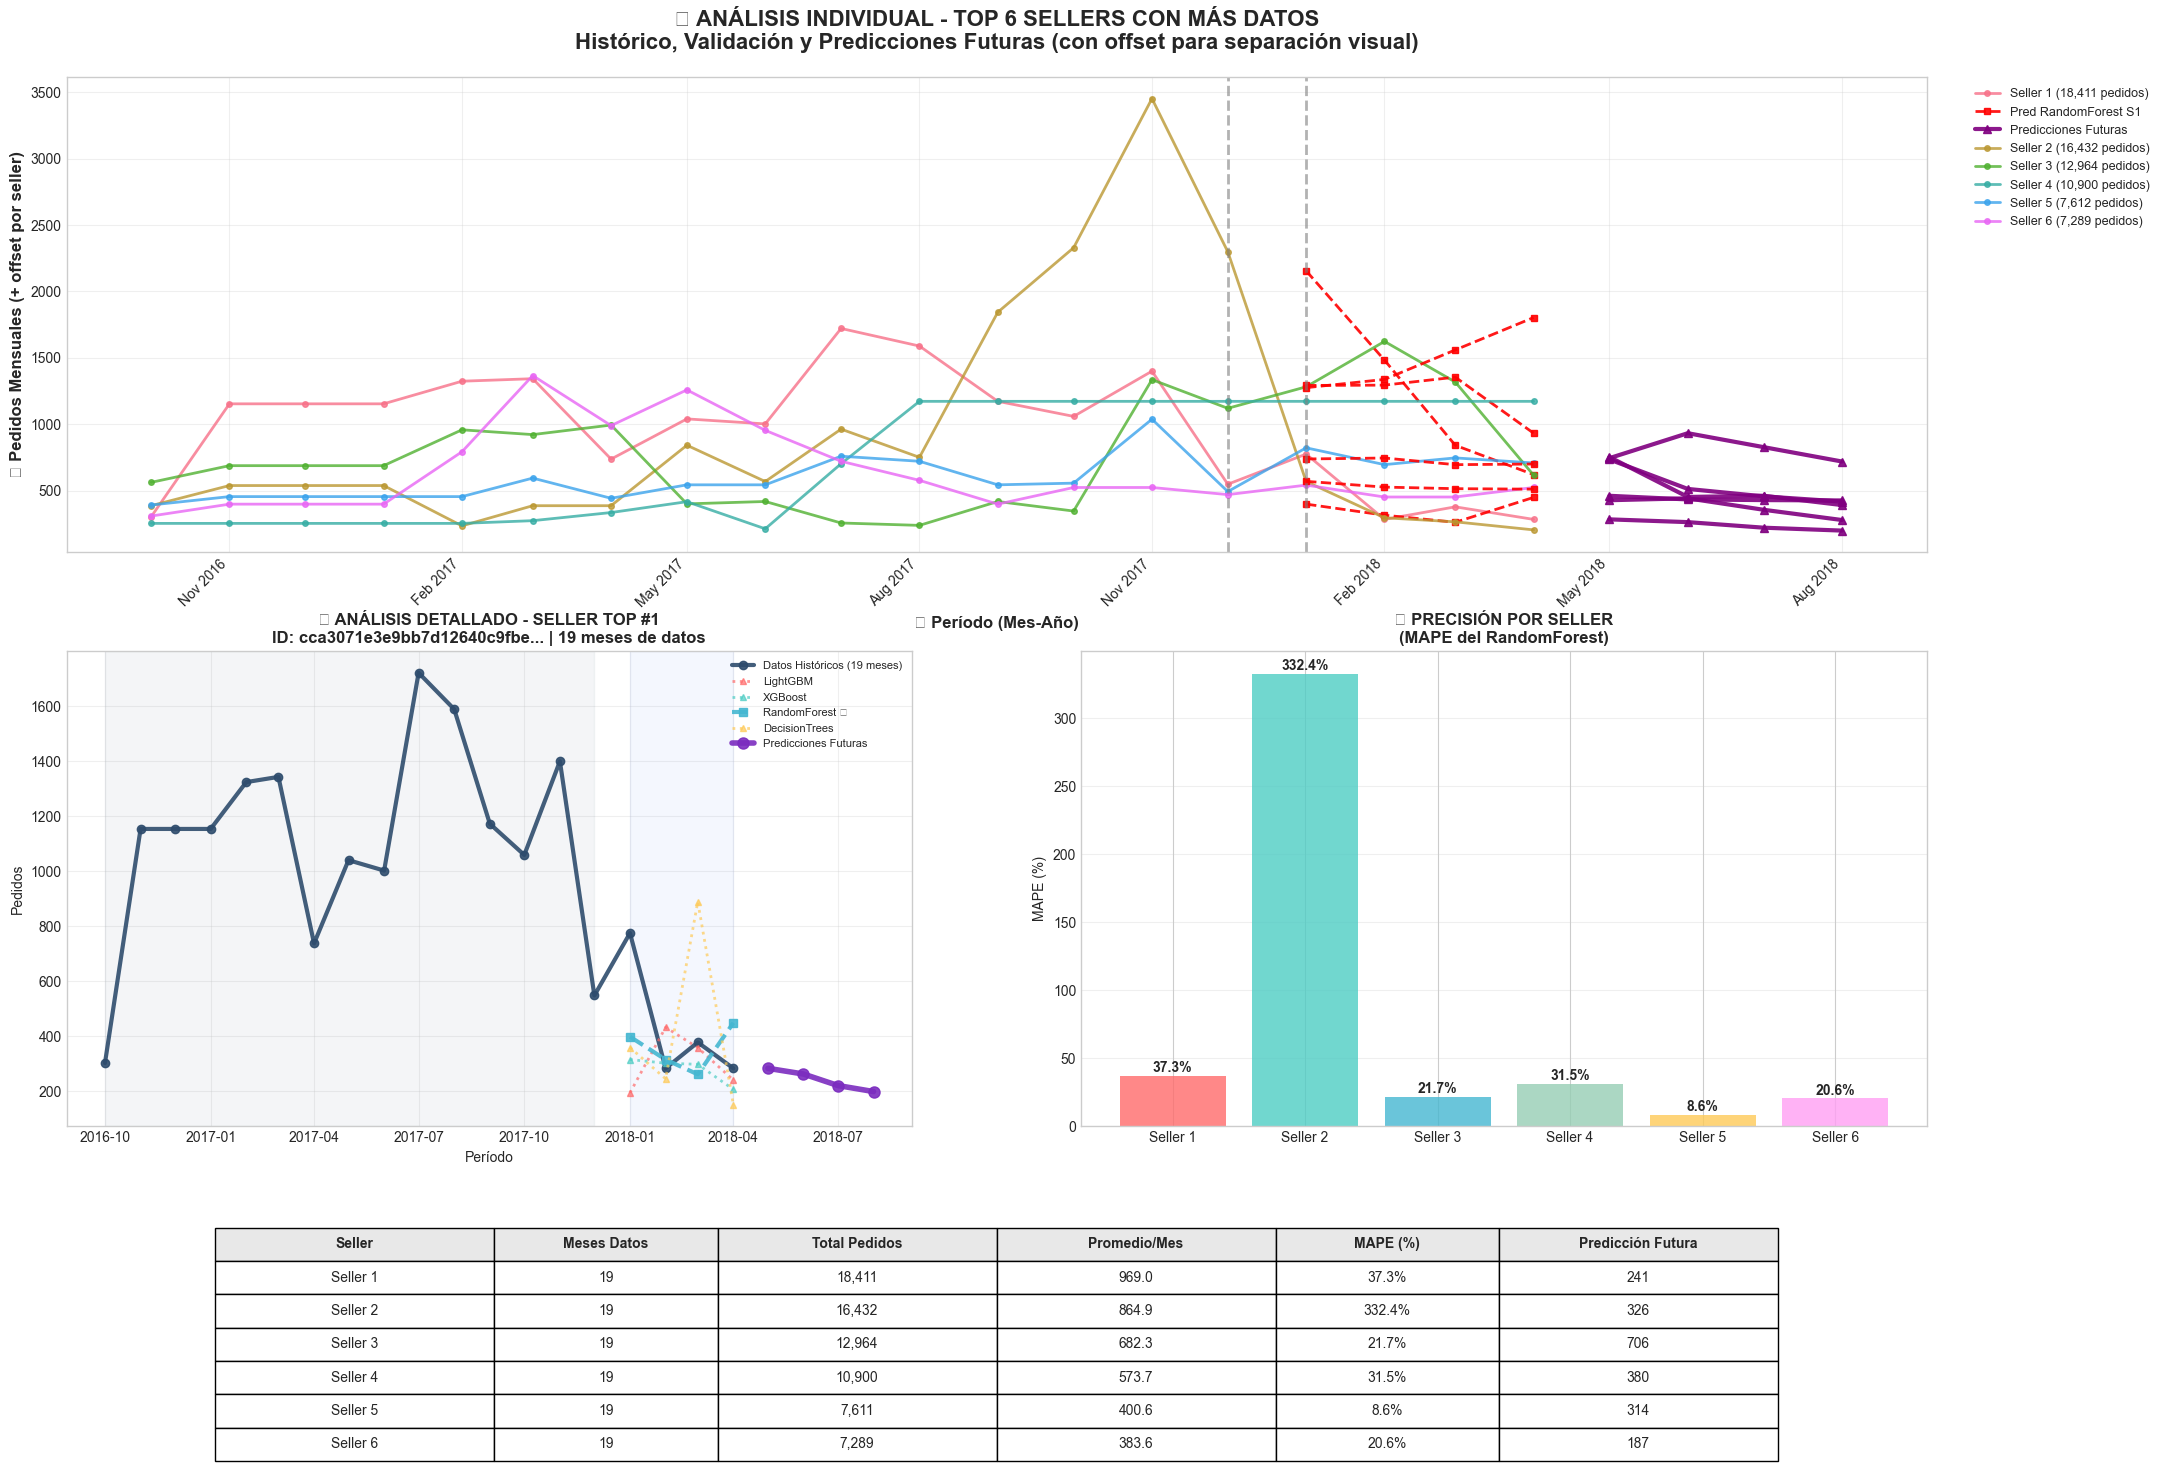


✅ ANÁLISIS POR SELLERS COMPLETADO
📄 Visualización lista para documento de análisis


In [ ]:
# 🏪 ANÁLISIS POR SELLERS INDIVIDUALES - LOS CON MÁS DATOS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

print("🏪 ANALIZANDO SELLERS INDIVIDUALES CON MÁS DATOS...")
print("=" * 70)

# 1. IDENTIFICAR SELLERS CON MÁS DATOS
# =====================================

# Analizar qué sellers tienen más registros históricos
seller_stats = df_processed.groupby(ids_col).agg({
    label_col: ['count', 'sum', 'mean', 'std'],
    date_col: ['min', 'max']
}).round(2)

# Aplanar columnas multi-nivel
seller_stats.columns = ['_'.join(col).strip() for col in seller_stats.columns]
seller_stats['meses_datos'] = seller_stats['pedidos_count']
seller_stats['total_pedidos'] = seller_stats['pedidos_sum']
seller_stats['promedio_mensual'] = seller_stats['pedidos_mean']

# Ordenar por número de meses de datos y total de pedidos
seller_stats = seller_stats.sort_values(['meses_datos', 'total_pedidos'], ascending=[False, False])

print("📊 TOP SELLERS POR CANTIDAD DE DATOS:")
print("====================================")
top_sellers = seller_stats.head(15)
for i, (seller_id, row) in enumerate(top_sellers.iterrows(), 1):
    print(f"{i:2d}. {seller_id[:20]}... | {int(row['meses_datos'])} meses | {int(row['total_pedidos']):,} pedidos | Prom: {row['promedio_mensual']:.1f}/mes")

# Seleccionar top 6 sellers para análisis detallado
selected_sellers = seller_stats.head(6).index.tolist()
print(f"\n🎯 SELLERS SELECCIONADOS PARA ANÁLISIS DETALLADO: {len(selected_sellers)}")

# 2. PREPARAR DATOS INDIVIDUALES POR SELLER
# ==========================================

# Datos históricos por seller
sellers_data = {}
sellers_test_predictions = {}
sellers_future_predictions = {}

print("\n🔄 Preparando datos individuales por seller...")

for seller_id in selected_sellers:
    # Datos históricos del seller
    seller_historical = df_processed[df_processed[ids_col] == seller_id].copy()
    seller_historical = seller_historical.sort_values(date_col)
    
    # Separar en train/test usando las mismas fechas
    seller_train = seller_historical[seller_historical[date_col] <= train_end_date].copy()
    seller_test = seller_historical[seller_historical[date_col] >= test_start_date].copy()
    
    # Predicciones de test para este seller
    seller_test_pred = test_predictions[test_predictions[ids_col] == seller_id].copy()
    
    # Reescalar predicciones para cada modelo
    seller_models_pred = {}
    for model_name in model_names:
        temp_pred = seller_test_pred.copy()
        temp_pred['predictions'] = temp_pred[model_name]
        temp_unscaled = scaler.inverse_transform(temp_pred[['seller_id', 'year_month', 'predictions']])
        seller_models_pred[model_name] = temp_unscaled
    
    # Predicciones futuras para este seller
    seller_future_pred = predictions[predictions[ids_col] == seller_id].copy()
    
    # Almacenar datos
    sellers_data[seller_id] = {
        'historical': seller_historical,
        'train': seller_train,
        'test': seller_test
    }
    sellers_test_predictions[seller_id] = seller_models_pred
    sellers_future_predictions[seller_id] = seller_future_pred

print(f"✅ Datos preparados para {len(selected_sellers)} sellers")

# 3. CREAR VISUALIZACIÓN PROFESIONAL POR SELLERS
# ===============================================

# Configurar figura grande con subplots
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 2, 1], hspace=0.25, wspace=0.2)

# Paleta de colores profesional
colors_sellers = {
    'historical': '#2E4C6D',
    'test': '#396DF2', 
    'future': '#7B2CBF',
    'LightGBM': '#FF6B6B',
    'XGBoost': '#4ECDC4',
    'RandomForest': '#45B7D1',
    #'ExtraTrees': '#96CEB4',
    'DecisionTrees': '#FECA57',
    #'LinearRegression': '#FF9FF3'
}

# 3.1 GRÁFICO PRINCIPAL - TOP 6 SELLERS
ax_main = fig.add_subplot(gs[0, :])

for i, seller_id in enumerate(selected_sellers):
    seller_data = sellers_data[seller_id]
    
    # Offset para separar visualmente los sellers
    offset = i * 50
    
    # Plot datos históricos
    ax_main.plot(seller_data['historical'][date_col], 
                seller_data['historical'][label_col] + offset,
                'o-', linewidth=2, markersize=4, alpha=0.8,
                label=f'Seller {i+1} ({seller_data["historical"][label_col].sum():,.0f} pedidos)')
    
    # Plot predicciones del modelo campeón
    if seller_id in sellers_test_predictions:
        champion_pred = sellers_test_predictions[seller_id][champion_model_name]
        ax_main.plot(champion_pred[date_col],
                    champion_pred['predictions'] + offset,
                    's--', linewidth=2, markersize=5, alpha=0.9,
                    color='red', label=f'Pred {champion_model_name} S{i+1}' if i == 0 else "")
    
    # Plot predicciones futuras
    if seller_id in sellers_future_predictions:
        future_pred = sellers_future_predictions[seller_id]
        ax_main.plot(future_pred[date_col],
                    future_pred['predictions'] + offset,
                    '^-', linewidth=3, markersize=6, alpha=0.9,
                    color='purple', label=f'Predicciones Futuras' if i == 0 else "")

# Líneas separadoras de períodos
ax_main.axvline(x=train_end_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)
ax_main.axvline(x=test_start_date, color='gray', linestyle='--', alpha=0.6, linewidth=2)

ax_main.set_title('📈 ANÁLISIS INDIVIDUAL - TOP 6 SELLERS CON MÁS DATOS\n' +
                 'Histórico, Validación y Predicciones Futuras (con offset para separación visual)',
                 fontsize=16, fontweight='bold', pad=20)
ax_main.set_xlabel('📅 Período (Mes-Año)', fontsize=12, fontweight='bold')
ax_main.set_ylabel('📦 Pedidos Mensuales (+ offset por seller)', fontsize=12, fontweight='bold')
ax_main.grid(True, alpha=0.3)
ax_main.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)

# Formato de fechas
ax_main.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_main.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax_main.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3.2 ANÁLISIS DETALLADO DE UN SELLER ESPECÍFICO
ax_detail = fig.add_subplot(gs[1, 0])

# Seleccionar el seller con más datos para análisis detallado
detail_seller = selected_sellers[0]
detail_data = sellers_data[detail_seller]

# Plot histórico completo
ax_detail.plot(detail_data['historical'][date_col], detail_data['historical'][label_col],
              'o-', color=colors_sellers['historical'], linewidth=3, markersize=6,
              label=f'Datos Históricos ({len(detail_data["historical"])} meses)', alpha=0.9)

# Plot predicciones de todos los modelos para este seller
if detail_seller in sellers_test_predictions:
    for model_name in model_names[:4]:  # Solo top 4 para claridad
        model_pred = sellers_test_predictions[detail_seller][model_name]
        is_champion = model_name == champion_model_name
        
        ax_detail.plot(model_pred[date_col], model_pred['predictions'],
                      's--' if is_champion else '^:', 
                      color=colors_sellers[model_name],
                      linewidth=3 if is_champion else 2,
                      markersize=6 if is_champion else 4,
                      alpha=0.9 if is_champion else 0.7,
                      label=f'{model_name}' + (' 🏆' if is_champion else ''))

# Plot predicciones futuras
if detail_seller in sellers_future_predictions:
    future_pred = sellers_future_predictions[detail_seller]
    ax_detail.plot(future_pred[date_col], future_pred['predictions'],
                  'o-', color=colors_sellers['future'], linewidth=4, markersize=8,
                  label='Predicciones Futuras', alpha=0.9)

# Áreas sombreadas
ax_detail.axvspan(detail_data['historical'][date_col].min(), train_end_date, 
                 alpha=0.05, color=colors_sellers['historical'])
ax_detail.axvspan(test_start_date, detail_data['test'][date_col].max() if len(detail_data['test']) > 0 else test_start_date, 
                 alpha=0.05, color=colors_sellers['test'])

ax_detail.set_title(f'🔍 ANÁLISIS DETALLADO - SELLER TOP #1\n' +
                   f'ID: {detail_seller[:25]}... | {len(detail_data["historical"])} meses de datos',
                   fontsize=12, fontweight='bold')
ax_detail.set_xlabel('Período', fontsize=10)
ax_detail.set_ylabel('Pedidos', fontsize=10)
ax_detail.grid(True, alpha=0.3)
ax_detail.legend(fontsize=8)

# 3.3 COMPARACIÓN DE PRECISIÓN POR SELLER
ax_accuracy = fig.add_subplot(gs[1, 1])

# Calcular métricas por seller
seller_accuracies = []
seller_labels = []

for i, seller_id in enumerate(selected_sellers):
    if seller_id in sellers_test_predictions and len(sellers_data[seller_id]['test']) > 0:
        # Datos reales de test del seller
        real_test = sellers_data[seller_id]['test']
        
        # Predicciones del modelo campeón
        champion_pred = sellers_test_predictions[seller_id][champion_model_name]
        
        # Merge para comparación
        comparison = pd.merge(real_test, champion_pred, on=date_col, how='inner')
        
        if len(comparison) > 0:
            mape = (abs(comparison[label_col] - comparison['predictions']) / comparison[label_col] * 100).mean()
            seller_accuracies.append(mape)
            seller_labels.append(f'Seller {i+1}')

# Gráfico de barras de precisión
if seller_accuracies:
    bars = ax_accuracy.bar(seller_labels, seller_accuracies, 
                          color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3'][:len(seller_accuracies)],
                          alpha=0.8)
    
    # Añadir valores en las barras
    for bar, acc in zip(bars, seller_accuracies):
        height = bar.get_height()
        ax_accuracy.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

ax_accuracy.set_title(f'🎯 PRECISIÓN POR SELLER\n(MAPE del {champion_model_name})', 
                     fontsize=12, fontweight='bold')
ax_accuracy.set_ylabel('MAPE (%)', fontsize=10)
ax_accuracy.grid(True, alpha=0.3, axis='y')

# 3.4 TABLA RESUMEN DE SELLERS
ax_table = fig.add_subplot(gs[2, :])
ax_table.axis('off')

# Crear tabla con estadísticas de los sellers seleccionados
table_data = []
table_headers = ['Seller', 'Meses Datos', 'Total Pedidos', 'Promedio/Mes', 'MAPE (%)', 'Predicción Futura']

for i, seller_id in enumerate(selected_sellers):
    seller_info = seller_stats.loc[seller_id]
    
    # MAPE si está disponible
    mape_str = f"{seller_accuracies[i]:.1f}%" if i < len(seller_accuracies) else "N/A"
    
    # Predicción futura promedio
    future_avg = "N/A"
    if seller_id in sellers_future_predictions:
        future_avg = f"{sellers_future_predictions[seller_id]['predictions'].mean():,.0f}"
    
    table_data.append([
        f"Seller {i+1}",
        f"{int(seller_info['meses_datos'])}",
        f"{int(seller_info['total_pedidos']):,}",
        f"{seller_info['promedio_mensual']:.1f}",
        mape_str,
        future_avg
    ])

table = ax_table.table(cellText=table_data, colLabels=table_headers,
                      cellLoc='center', loc='center', colWidths=[0.15, 0.12, 0.15, 0.15, 0.12, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilo de la tabla
for i in range(len(table_headers)):
    table[(0, i)].set_facecolor('#E8E8E8')
    table[(0, i)].set_text_props(weight='bold')

plt.tight_layout()

# 4. ESTADÍSTICAS RESUMEN
print("\n" + "="*70)
print("📊 RESUMEN ESTADÍSTICO - ANÁLISIS POR SELLERS")
print("="*70)

print(f"\n🏪 SELLERS ANALIZADOS: {len(selected_sellers)}")
print(f"📅 PERÍODO DE ANÁLISIS: {df_processed[date_col].min().strftime('%B %Y')} - {df_processed[date_col].max().strftime('%B %Y')}")

print(f"\n📈 ESTADÍSTICAS DE LOS TOP SELLERS:")
for i, seller_id in enumerate(selected_sellers):
    seller_info = seller_stats.loc[seller_id]
    print(f"  {i+1}. Seller {i+1}:")
    print(f"     • Meses con datos: {int(seller_info['meses_datos'])}")
    print(f"     • Total pedidos históricos: {int(seller_info['total_pedidos']):,}")
    print(f"     • Promedio mensual: {seller_info['promedio_mensual']:.1f} pedidos")
    print(f"     • Período: {seller_info['year_month_min'].strftime('%m/%Y')} - {seller_info['year_month_max'].strftime('%m/%Y')}")

if seller_accuracies:
    print(f"\n🎯 PRECISIÓN DEL MODELO {champion_model_name}:")
    for i, (acc, seller_id) in enumerate(zip(seller_accuracies, selected_sellers)):
        print(f"  • Seller {i+1}: {acc:.1f}% MAPE")
    
    print(f"\n📊 RESUMEN DE PRECISIÓN:")
    print(f"  • Mejor precisión: {min(seller_accuracies):.1f}% MAPE")
    print(f"  • Peor precisión: {max(seller_accuracies):.1f}% MAPE")
    print(f"  • Promedio: {np.mean(seller_accuracies):.1f}% MAPE")

plt.show()
print("\n✅ ANÁLISIS POR SELLERS COMPLETADO")
print("📄 Visualización lista para documento de análisis")
print("="*70)

🔍 CREANDO ANÁLISIS COMPARATIVO DETALLADO POR SELLERS...
🎯 SELLERS SELECCIONADOS PARA COMPARACIÓN DETALLADA:
  1. Seller cca3071e3e9bb7d12640c9fbe...
     • 19 meses | 18,411 pedidos | Prom: 969.0/mes
  2. Seller 46dc3b2cc0980fb8ec44634e2...
     • 19 meses | 16,432 pedidos | Prom: 864.9/mes
  3. Seller 620c87c171fb2a6dd6e8bb4de...
     • 19 meses | 12,964 pedidos | Prom: 682.3/mes
  4. Seller ce27a3cc3c8cc1ea79d11e561...
     • 19 meses | 10,900 pedidos | Prom: 573.7/mes


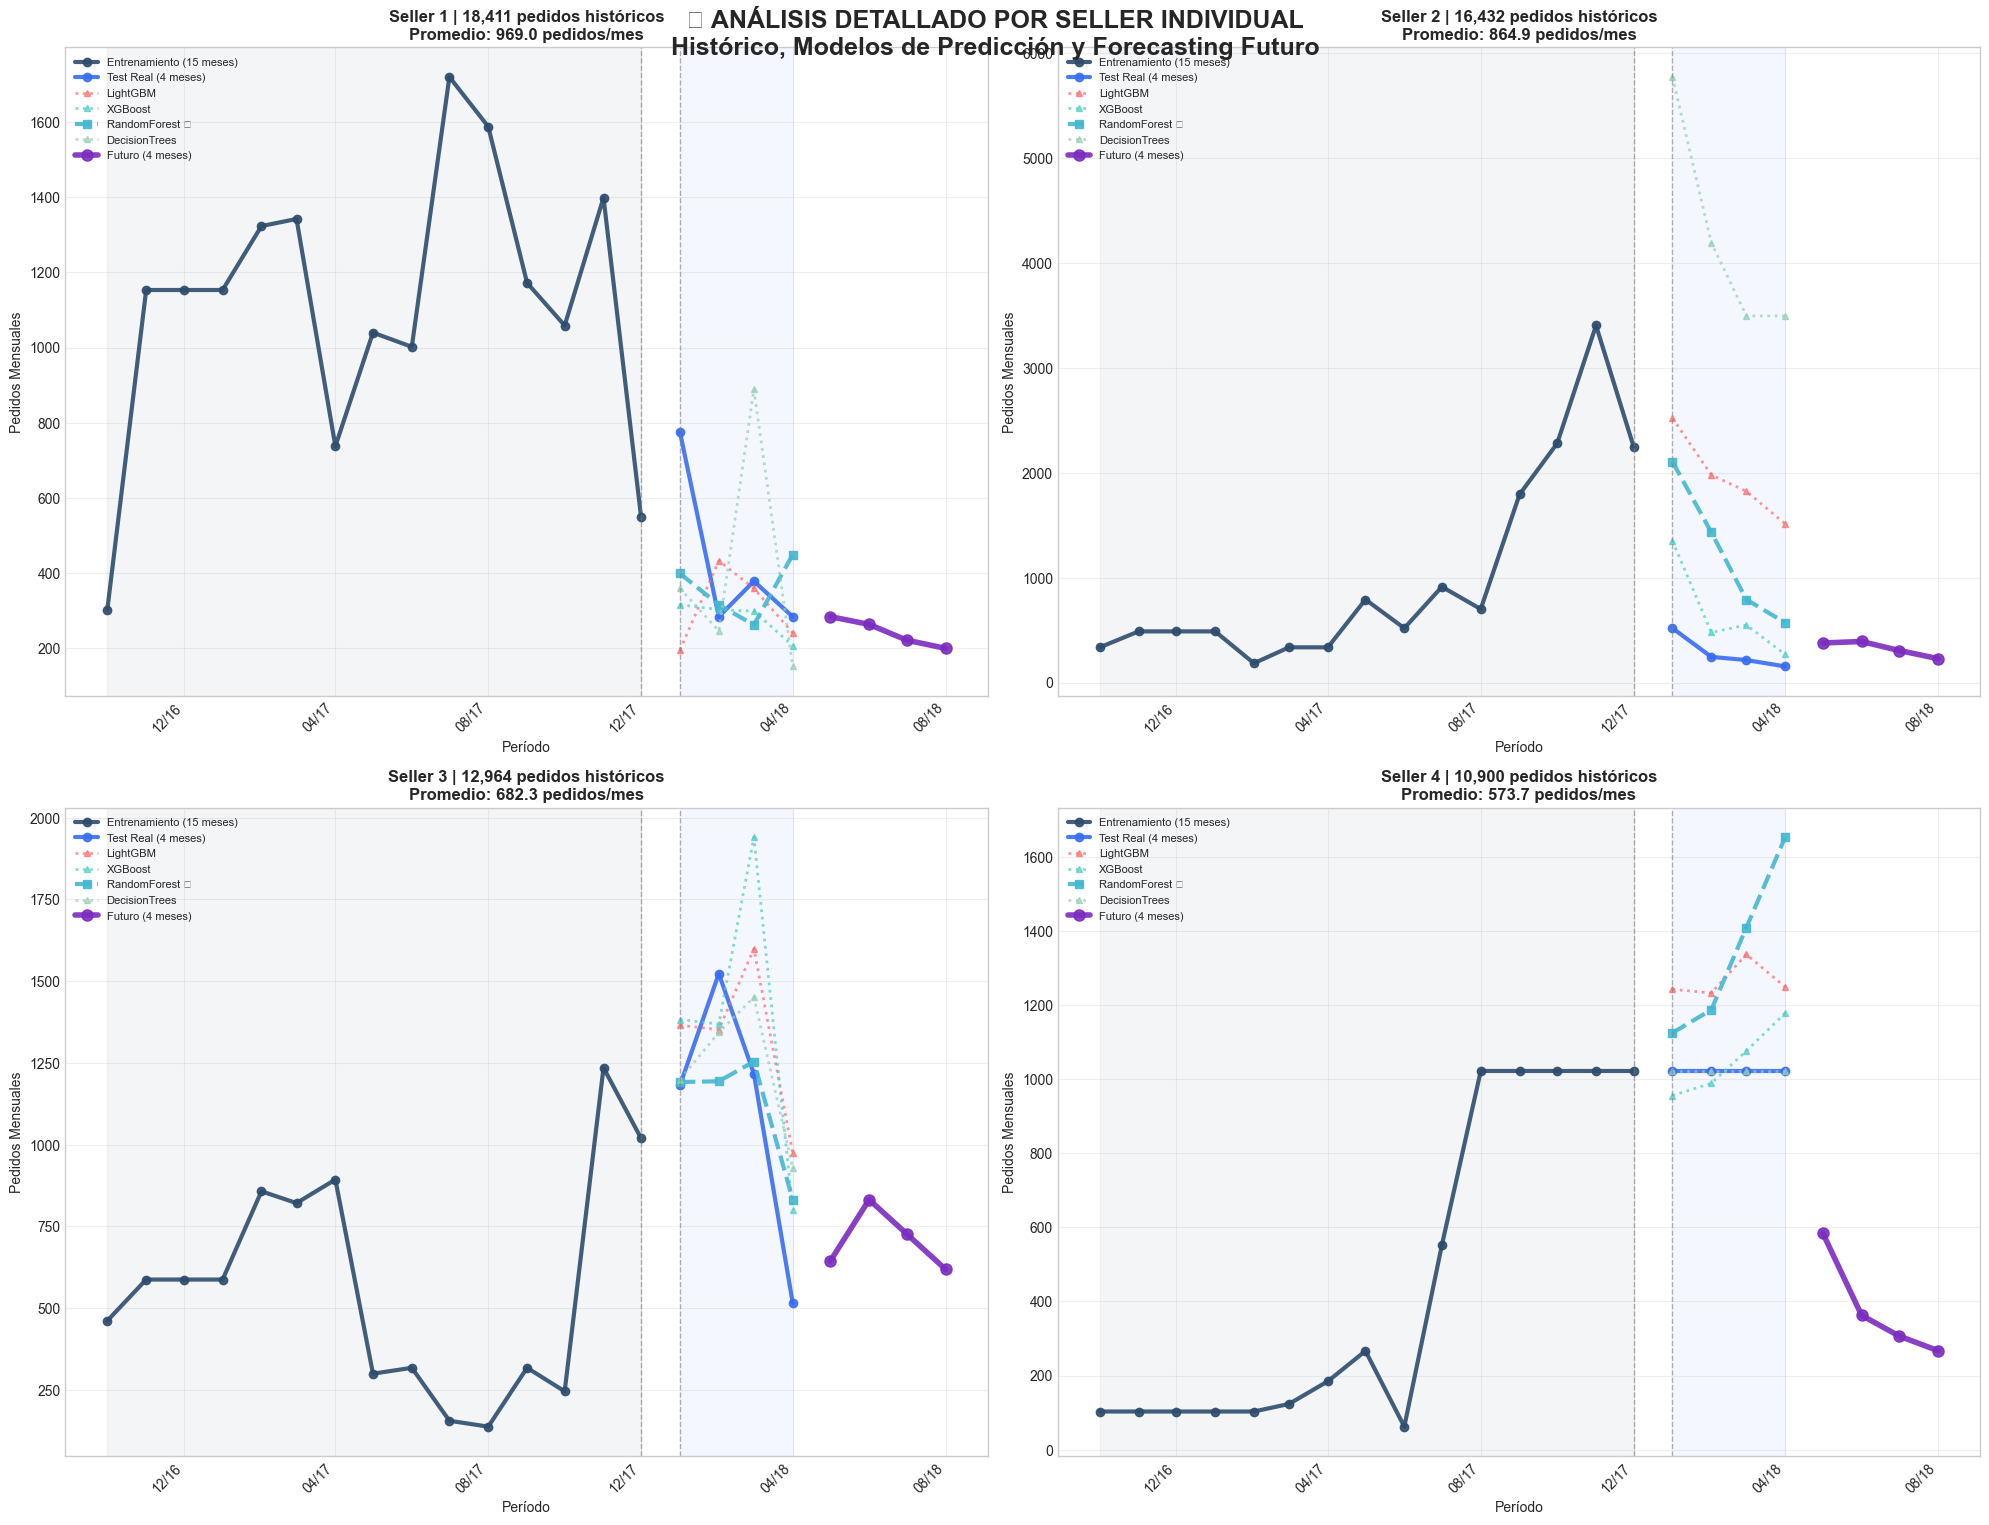

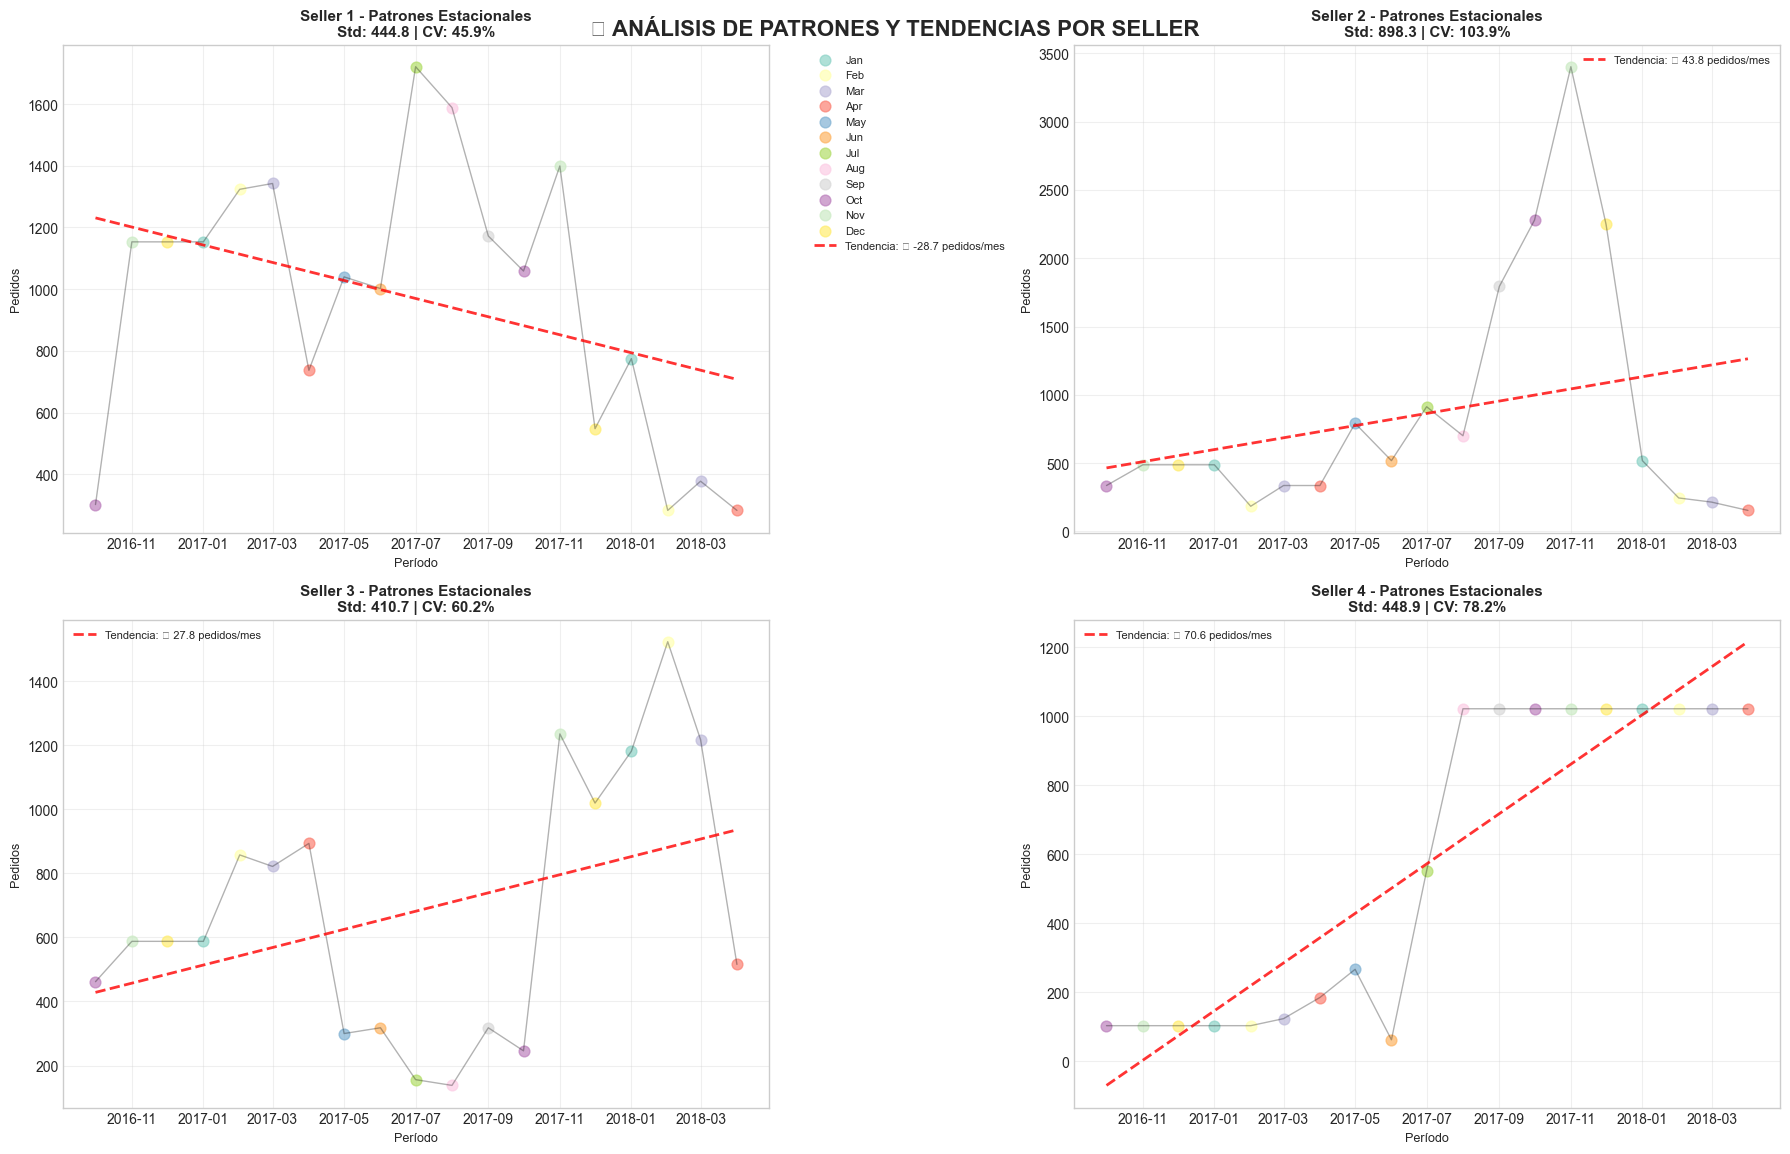


📊 TABLA COMPARATIVA DETALLADA DE SELLERS
Seller     Meses  Total    Prom/Mes Std    CV%   Tendencia    MAPE%  Pred.Fut Cambio  
--------------------------------------------------------------------------------
Seller 1   19     18,411   969.0    444.8  45.9 % Decrecimiento 37.3   241.1    -75.1%  
Seller 2   19     16,432   864.8    898.3  103.9% Crecimiento  332.4  325.7    -62.3%  
Seller 3   19     12,964   682.3    410.7  60.2 % Crecimiento  21.7   705.6    +3.4%   
Seller 4   19     10,900   573.7    448.9  78.2 % Crecimiento  31.5   380.0    -33.8%  

🔍 INSIGHTS DEL ANÁLISIS POR SELLERS:
📊 SELLER MÁS ESTABLE: Seller 1 (CV: 45.9%)
📈 MEJOR CRECIMIENTO: Seller 4 (+70.56 pedidos/mes)
🎯 PREDICCIÓN MÁS PRECISA: Seller 3 (MAPE: 21.7%)
📦 MAYOR VOLUMEN HISTÓRICO: Seller 1 (18,411 pedidos)

✅ ANÁLISIS COMPARATIVO COMPLETADO
📋 Datos listos para toma de decisiones por seller individual


In [ ]:
# 🔍 ANÁLISIS COMPARATIVO DETALLADO - SELLERS INDIVIDUALES
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

print("🔍 CREANDO ANÁLISIS COMPARATIVO DETALLADO POR SELLERS...")
print("=" * 65)

# 1. SELECCIONAR SELLERS PARA ANÁLISIS COMPARATIVO DETALLADO
# ==========================================================

# Seleccionar 4 sellers con diferentes patrones
comparison_sellers = selected_sellers[:4]  # Top 4 sellers
print(f"🎯 SELLERS SELECCIONADOS PARA COMPARACIÓN DETALLADA:")

for i, seller_id in enumerate(comparison_sellers):
    seller_info = seller_stats.loc[seller_id]
    print(f"  {i+1}. Seller {seller_id[:25]}...")
    print(f"     • {int(seller_info['meses_datos'])} meses | {int(seller_info['total_pedidos']):,} pedidos | Prom: {seller_info['promedio_mensual']:.1f}/mes")

# 2. CREAR GRÁFICOS INDIVIDUALES DETALLADOS
# ==========================================

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('🏪 ANÁLISIS DETALLADO POR SELLER INDIVIDUAL\nHistórico, Modelos de Predicción y Forecasting Futuro', 
             fontsize=18, fontweight='bold', y=0.95)

axes = axes.flatten()

for idx, seller_id in enumerate(comparison_sellers):
    ax = axes[idx]
    seller_data = sellers_data[seller_id]
    seller_info = seller_stats.loc[seller_id]
    
    # Datos históricos completos
    historical = seller_data['historical']
    train_data = seller_data['train'] 
    test_data = seller_data['test']
    
    # Plot datos históricos separados por período
    if len(train_data) > 0:
        ax.plot(train_data[date_col], train_data[label_col], 
               'o-', color='#2E4C6D', linewidth=3, markersize=6, 
               label=f'Entrenamiento ({len(train_data)} meses)', alpha=0.9)
    
    if len(test_data) > 0:
        ax.plot(test_data[date_col], test_data[label_col], 
               'o-', color='#396DF2', linewidth=3, markersize=6, 
               label=f'Test Real ({len(test_data)} meses)', alpha=0.9)
    
    # Plot predicciones de test de múltiples modelos
    if seller_id in sellers_test_predictions:
        model_colors_comp = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        models_to_show = model_names[:4]  # Top 4 modelos
        
        for i, model_name in enumerate(models_to_show):
            model_pred = sellers_test_predictions[seller_id][model_name]
            is_champion = model_name == champion_model_name
            
            ax.plot(model_pred[date_col], model_pred['predictions'],
                   's--' if is_champion else '^:', 
                   color=model_colors_comp[i], 
                   linewidth=3 if is_champion else 2,
                   markersize=6 if is_champion else 4,
                   alpha=0.9 if is_champion else 0.7,
                   label=f'{model_name}' + (' 🏆' if is_champion else ''))
    
    # Plot predicciones futuras
    if seller_id in sellers_future_predictions:
        future_pred = sellers_future_predictions[seller_id]
        ax.plot(future_pred[date_col], future_pred['predictions'],
               'o-', color='#7B2CBF', linewidth=4, markersize=8,
               label=f'Futuro ({len(future_pred)} meses)', alpha=0.9)
    
    # Líneas separadoras
    ax.axvline(x=train_end_date, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    ax.axvline(x=test_start_date, color='gray', linestyle='--', alpha=0.6, linewidth=1)
    
    # Áreas sombreadas
    if len(historical) > 0:
        ax.axvspan(historical[date_col].min(), train_end_date, alpha=0.05, color='#2E4C6D')
        if len(test_data) > 0:
            ax.axvspan(test_start_date, test_data[date_col].max(), alpha=0.05, color='#396DF2')
    
    # Configuración individual del subplot
    ax.set_title(f'Seller {idx+1} | {int(seller_info["total_pedidos"]):,} pedidos históricos\n' +
                f'Promedio: {seller_info["promedio_mensual"]:.1f} pedidos/mes',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Período', fontsize=10)
    ax.set_ylabel('Pedidos Mensuales', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper left')
    
    # Formato de fechas
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 3. ANÁLISIS DE PATRONES Y ESTACIONALIDAD POR SELLER
# ===================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📈 ANÁLISIS DE PATRONES Y TENDENCIAS POR SELLER', 
             fontsize=16, fontweight='bold', y=0.95)

axes = axes.flatten()

for idx, seller_id in enumerate(comparison_sellers):
    ax = axes[idx]
    seller_data = sellers_data[seller_id]
    historical = seller_data['historical'].copy()
    
    if len(historical) > 0:
        # Agregar información de mes para análisis estacional
        historical['month'] = historical[date_col].dt.month
        historical['year'] = historical[date_col].dt.year
        
        # Crear gráfico de líneas con marcadores de meses
        colors_months = plt.cm.Set3(np.linspace(0, 1, 12))
        
        for month in sorted(historical['month'].unique()):
            month_data = historical[historical['month'] == month]
            month_name = pd.to_datetime(f'2023-{month:02d}-01').strftime('%b')
            
            ax.scatter(month_data[date_col], month_data[label_col], 
                      color=colors_months[month-1], s=60, alpha=0.7,
                      label=month_name if idx == 0 else "")
        
        # Línea de tendencia
        ax.plot(historical[date_col], historical[label_col], 
               'k-', alpha=0.3, linewidth=1)
        
        # Calcular tendencia general
        x_numeric = (historical[date_col] - historical[date_col].iloc[0]).dt.days
        z = np.polyfit(x_numeric, historical[label_col], 1)
        p = np.poly1d(z)
        ax.plot(historical[date_col], p(x_numeric), 
               "r--", alpha=0.8, linewidth=2, 
               label=f'Tendencia: {"↗" if z[0] > 0 else "↘"} {z[0]*30:.1f} pedidos/mes')
    
    seller_info = seller_stats.loc[seller_id]
    ax.set_title(f'Seller {idx+1} - Patrones Estacionales\n' +
                f'Std: {seller_info["pedidos_std"]:.1f} | CV: {(seller_info["pedidos_std"]/seller_info["pedidos_mean"]*100):.1f}%',
                fontsize=11, fontweight='bold')
    ax.set_xlabel('Período', fontsize=9)
    ax.set_ylabel('Pedidos', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if idx == 0:  # Solo mostrar leyenda de meses en el primer gráfico
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
    else:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# 4. TABLA COMPARATIVA DETALLADA
# ===============================

print("\n📊 TABLA COMPARATIVA DETALLADA DE SELLERS")
print("=" * 80)

# Crear DataFrame comparativo
comparison_data = []

for i, seller_id in enumerate(comparison_sellers):
    seller_info = seller_stats.loc[seller_id]
    
    # Calcular métricas adicionales
    historical = sellers_data[seller_id]['historical']
    
    # Tendencia
    if len(historical) > 1:
        x_numeric = (historical[date_col] - historical[date_col].iloc[0]).dt.days
        trend_slope = np.polyfit(x_numeric, historical[label_col], 1)[0] * 30  # Por mes
        trend_dir = "Crecimiento" if trend_slope > 0 else "Decrecimiento"
    else:
        trend_slope = 0
        trend_dir = "Estable"
    
    # Variabilidad
    cv = (seller_info['pedidos_std'] / seller_info['pedidos_mean']) * 100 if seller_info['pedidos_mean'] > 0 else 0
    
    # MAPE si está disponible
    mape_value = seller_accuracies[i] if i < len(seller_accuracies) else None
    
    # Predicción futura
    future_avg = sellers_future_predictions[seller_id]['predictions'].mean() if seller_id in sellers_future_predictions else None
    future_change = ((future_avg / seller_info['pedidos_mean'] - 1) * 100) if future_avg and seller_info['pedidos_mean'] > 0 else None
    
    comparison_data.append({
        'Seller': f'Seller {i+1}',
        'Meses_Datos': int(seller_info['meses_datos']),
        'Total_Pedidos': int(seller_info['total_pedidos']),
        'Promedio_Mensual': round(seller_info['promedio_mensual'], 1),
        'Desv_Estandar': round(seller_info['pedidos_std'], 1),
        'Coef_Variacion': round(cv, 1),
        'Tendencia': trend_dir,
        'Pendiente_Mensual': round(trend_slope, 2),
        'MAPE_Precision': round(mape_value, 1) if mape_value else 'N/A',
        'Pred_Futura_Prom': round(future_avg, 1) if future_avg else 'N/A',
        'Cambio_Esperado': f"{future_change:+.1f}%" if future_change else 'N/A'
    })

comparison_df = pd.DataFrame(comparison_data)

# Mostrar tabla formateada
print(f"{'Seller':<10} {'Meses':<6} {'Total':<8} {'Prom/Mes':<8} {'Std':<6} {'CV%':<5} {'Tendencia':<12} {'MAPE%':<6} {'Pred.Fut':<8} {'Cambio':<8}")
print("-" * 80)

for _, row in comparison_df.iterrows():
    print(f"{row['Seller']:<10} {row['Meses_Datos']:<6} {row['Total_Pedidos']:<8,} {row['Promedio_Mensual']:<8} {row['Desv_Estandar']:<6} {row['Coef_Variacion']:<5}% {row['Tendencia']:<12} {row['MAPE_Precision']:<6} {row['Pred_Futura_Prom']:<8} {row['Cambio_Esperado']:<8}")

# 5. INSIGHTS Y CONCLUSIONES
print(f"\n🔍 INSIGHTS DEL ANÁLISIS POR SELLERS:")
print("=" * 50)

# Seller más estable
most_stable = comparison_df.loc[comparison_df['Coef_Variacion'].idxmin()]
print(f"📊 SELLER MÁS ESTABLE: {most_stable['Seller']} (CV: {most_stable['Coef_Variacion']}%)")

# Seller con mejor crecimiento
growth_sellers = comparison_df[comparison_df['Tendencia'] == 'Crecimiento']
if len(growth_sellers) > 0:
    best_growth = growth_sellers.loc[growth_sellers['Pendiente_Mensual'].idxmax()]
    print(f"📈 MEJOR CRECIMIENTO: {best_growth['Seller']} (+{best_growth['Pendiente_Mensual']} pedidos/mes)")

# Seller más preciso en predicciones
numeric_mape = comparison_df[comparison_df['MAPE_Precision'] != 'N/A']['MAPE_Precision']
if len(numeric_mape) > 0:
    most_accurate_idx = numeric_mape.idxmin()
    most_accurate = comparison_df.iloc[most_accurate_idx]
    print(f"🎯 PREDICCIÓN MÁS PRECISA: {most_accurate['Seller']} (MAPE: {most_accurate['MAPE_Precision']}%)")

# Seller con mayor volumen
highest_volume = comparison_df.loc[comparison_df['Total_Pedidos'].idxmax()]
print(f"📦 MAYOR VOLUMEN HISTÓRICO: {highest_volume['Seller']} ({highest_volume['Total_Pedidos']:,} pedidos)")

print(f"\n✅ ANÁLISIS COMPARATIVO COMPLETADO")
print("📋 Datos listos para toma de decisiones por seller individual")
print("=" * 65)

In [ ]:
# === EXPORT: trabaja con test_predictions multi-modelo ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

# -------- Config mínima (usamos lo que ya tienes en el entorno) --------
assert 'test_predictions' in globals(), "No existe test_predictions (ejecuta run_training_pipeline primero)."
assert 'date_col' in globals(), "Falta date_col (ej. 'year_month')."
assert 'label_col' in globals(), "Falta label_col (ej. 'pedidos')."
tp = test_predictions.copy()

# ids_col puede existir o no; si existe, agregamos globalmente
ids = None
if 'ids_col' in globals() and isinstance(ids_col, str) and ids_col in tp.columns:
    ids = ids_col

# -------- Detectar columnas de modelos (todas menos fecha, label e id) --------
exclude = {date_col, label_col}
if ids: exclude.add(ids)
model_cols = [c for c in tp.columns if c not in exclude]
if not model_cols:
    raise ValueError(f"No se detectan columnas de modelos en test_predictions. Columnas: {tp.columns.tolist()}")

# -------- Agregación global mensual (sumando sellers si aplica) --------
if ids and ids in tp.columns:
    agg_true = tp.groupby(tp[date_col])[label_col].sum().rename('y_true')
    preds_agg = tp.groupby(tp[date_col])[model_cols].sum()
    agg = pd.concat([agg_true, preds_agg], axis=1).reset_index()
else:
    agg = tp[[date_col, label_col] + model_cols].rename(columns={label_col: 'y_true'}).copy()

agg = agg.sort_values(date_col).reset_index(drop=True)

# -------- Métricas por modelo y selección de campeón --------
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1e-9
    return 100*np.mean(2*np.abs(y_pred - y_true)/denom)

metrics_rows = []
for mcol in model_cols:
    y_true = agg['y_true'].values
    y_pred = agg[mcol].values
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = 100*np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-9, None)))
    sm   = smape(y_true, y_pred)
    metrics_rows.append({"Modelo": mcol, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape, "sMAPE (%)": sm})

metrics_df = pd.DataFrame(metrics_rows).sort_values("sMAPE (%)").reset_index(drop=True)
metrics_df.to_csv("figs/resultados_metricas.csv", index=False)
print("Métricas por modelo (ordenadas por sMAPE asc):")
display(metrics_df)

# Si ya tienes champion_model_name definido, priorízalo. Si no, el de mejor sMAPE.
if 'champion_model_name' in globals() and champion_model_name in model_cols:
    champion_name = champion_model_name
else:
    champion_name = metrics_df.loc[0, "Modelo"]

print(f"\n🏆 Modelo campeón seleccionado para gráficas: {champion_name}")

# -------- Figuras usando el campeón --------
# 1) Curva real vs pred
plt.figure(figsize=(8,3.5))
plt.plot(agg[date_col], agg['y_true'], label="Real")
plt.plot(agg[date_col], agg[champion_name], label=f"Predicción ({champion_name})")
plt.title("Pedidos mensuales: real vs predicción (holdout)")
plt.xlabel("Mes"); plt.ylabel("Pedidos"); plt.legend(); plt.tight_layout()
plt.savefig("figs/pedidos_pred_vs_real.pdf"); plt.close()

# 2) Residuales en el tiempo
res = agg['y_true'] - agg[champion_name]
plt.figure(figsize=(8,3))
plt.plot(agg[date_col], res, marker="o")
plt.axhline(0, linestyle="--")
plt.title(f"Residuales mensuales (real − pred) — {champion_name}"); plt.tight_layout()
plt.savefig("figs/residuales_temporales.pdf"); plt.close()

# 3) Histograma de residuales
plt.figure(figsize=(6,3.2))
bins = min(12, max(6, len(res)//2))
plt.hist(res, bins=bins)
plt.title("Histograma de residuales"); plt.tight_layout()
plt.savefig("figs/hist_residuales.pdf"); plt.close()

# 4) Scatter real vs pred
plt.figure(figsize=(4.2,4.2))
plt.scatter(agg['y_true'], agg[champion_name], alpha=0.85)
mx = max(agg['y_true'].max(), agg[champion_name].max()) * 1.05
plt.plot([0,mx], [0,mx], '--')
plt.xlabel("Real"); plt.ylabel("Predicción")
plt.title(f"Real vs pred (holdout) — {champion_name}")
plt.tight_layout(); plt.savefig("figs/scatter_real_vs_pred.pdf"); plt.close()

print("✅ Export: figs/pedidos_pred_vs_real.pdf, residuales_temporales.pdf, hist_residuales.pdf, scatter_real_vs_pred.pdf")


# (Opcional) Importancia de variables si tienes el objeto champion_model disponible
try:
    if 'champion_model' in globals() and hasattr(champion_model, "feature_importances_"):
        importances = np.asarray(champion_model.feature_importances_, dtype=float)
        # nombres de features: intenta varios atributos conocidos
        feat_names = (getattr(champion_model, "feature_name_", None) or
                      getattr(champion_model, "feature_names_in_", None))
        if feat_names is None:
            # último recurso: si existe df_processed con columnas
            if 'df_processed' in globals() and isinstance(df_processed, pd.DataFrame):
                feat_names = [c for c in df_processed.columns if c not in [date_col, label_col] and df_processed[c].dtype != 'O']
            else:
                feat_names = [f"feat_{i}" for i in range(len(importances))]

        fi = (pd.DataFrame({"feature": list(feat_names), "importance": importances})
                .sort_values("importance", ascending=False).head(20))
        fi = fi.iloc[::-1]  # para graficar de abajo arriba

        plt.figure(figsize=(8,4))
        plt.barh(fi["feature"], fi["importance"])
        plt.title(f"Importancia de variables (top 20) — {champion_name}")
        plt.tight_layout(); plt.savefig("figs/feature_importance.pdf"); plt.close()
        print("✅ Export: figs/feature_importance.pdf")
    else:
        print("ℹ️ No hay champion_model con feature_importances_. Omito feature_importance.pdf.")
except Exception as e:
    print("No se pudo generar feature_importance.pdf:", e)


Métricas por modelo (ordenadas por sMAPE asc):


,Modelo,MAE,RMSE,MAPE (%),sMAPE (%)
0,RandomForest,934.186780,1080.169035,20.526070,18.045308
1,XGBoost,1348.575687,1461.647254,29.489460,25.126854
2,LightGBM,1670.844765,1885.256970,36.614966,29.738234
3,DecisionTrees,1829.750000,1984.239338,39.956133,32.380959



🏆 Modelo campeón seleccionado para gráficas: RandomForest
✅ Export: figs/pedidos_pred_vs_real.pdf, residuales_temporales.pdf, hist_residuales.pdf, scatter_real_vs_pred.pdf
ℹ️ No hay champion_model con feature_importances_. Omito feature_importance.pdf.


💼 GENERANDO DASHBOARD DE ANÁLISIS DE NEGOCIO...
✅ Datos de negocio preparados:
   💰 Ingresos históricos totales: $78,810,312
   📈 Beneficio histórico total: $59,107,734
   📊 Margen promedio histórico: 75.0%


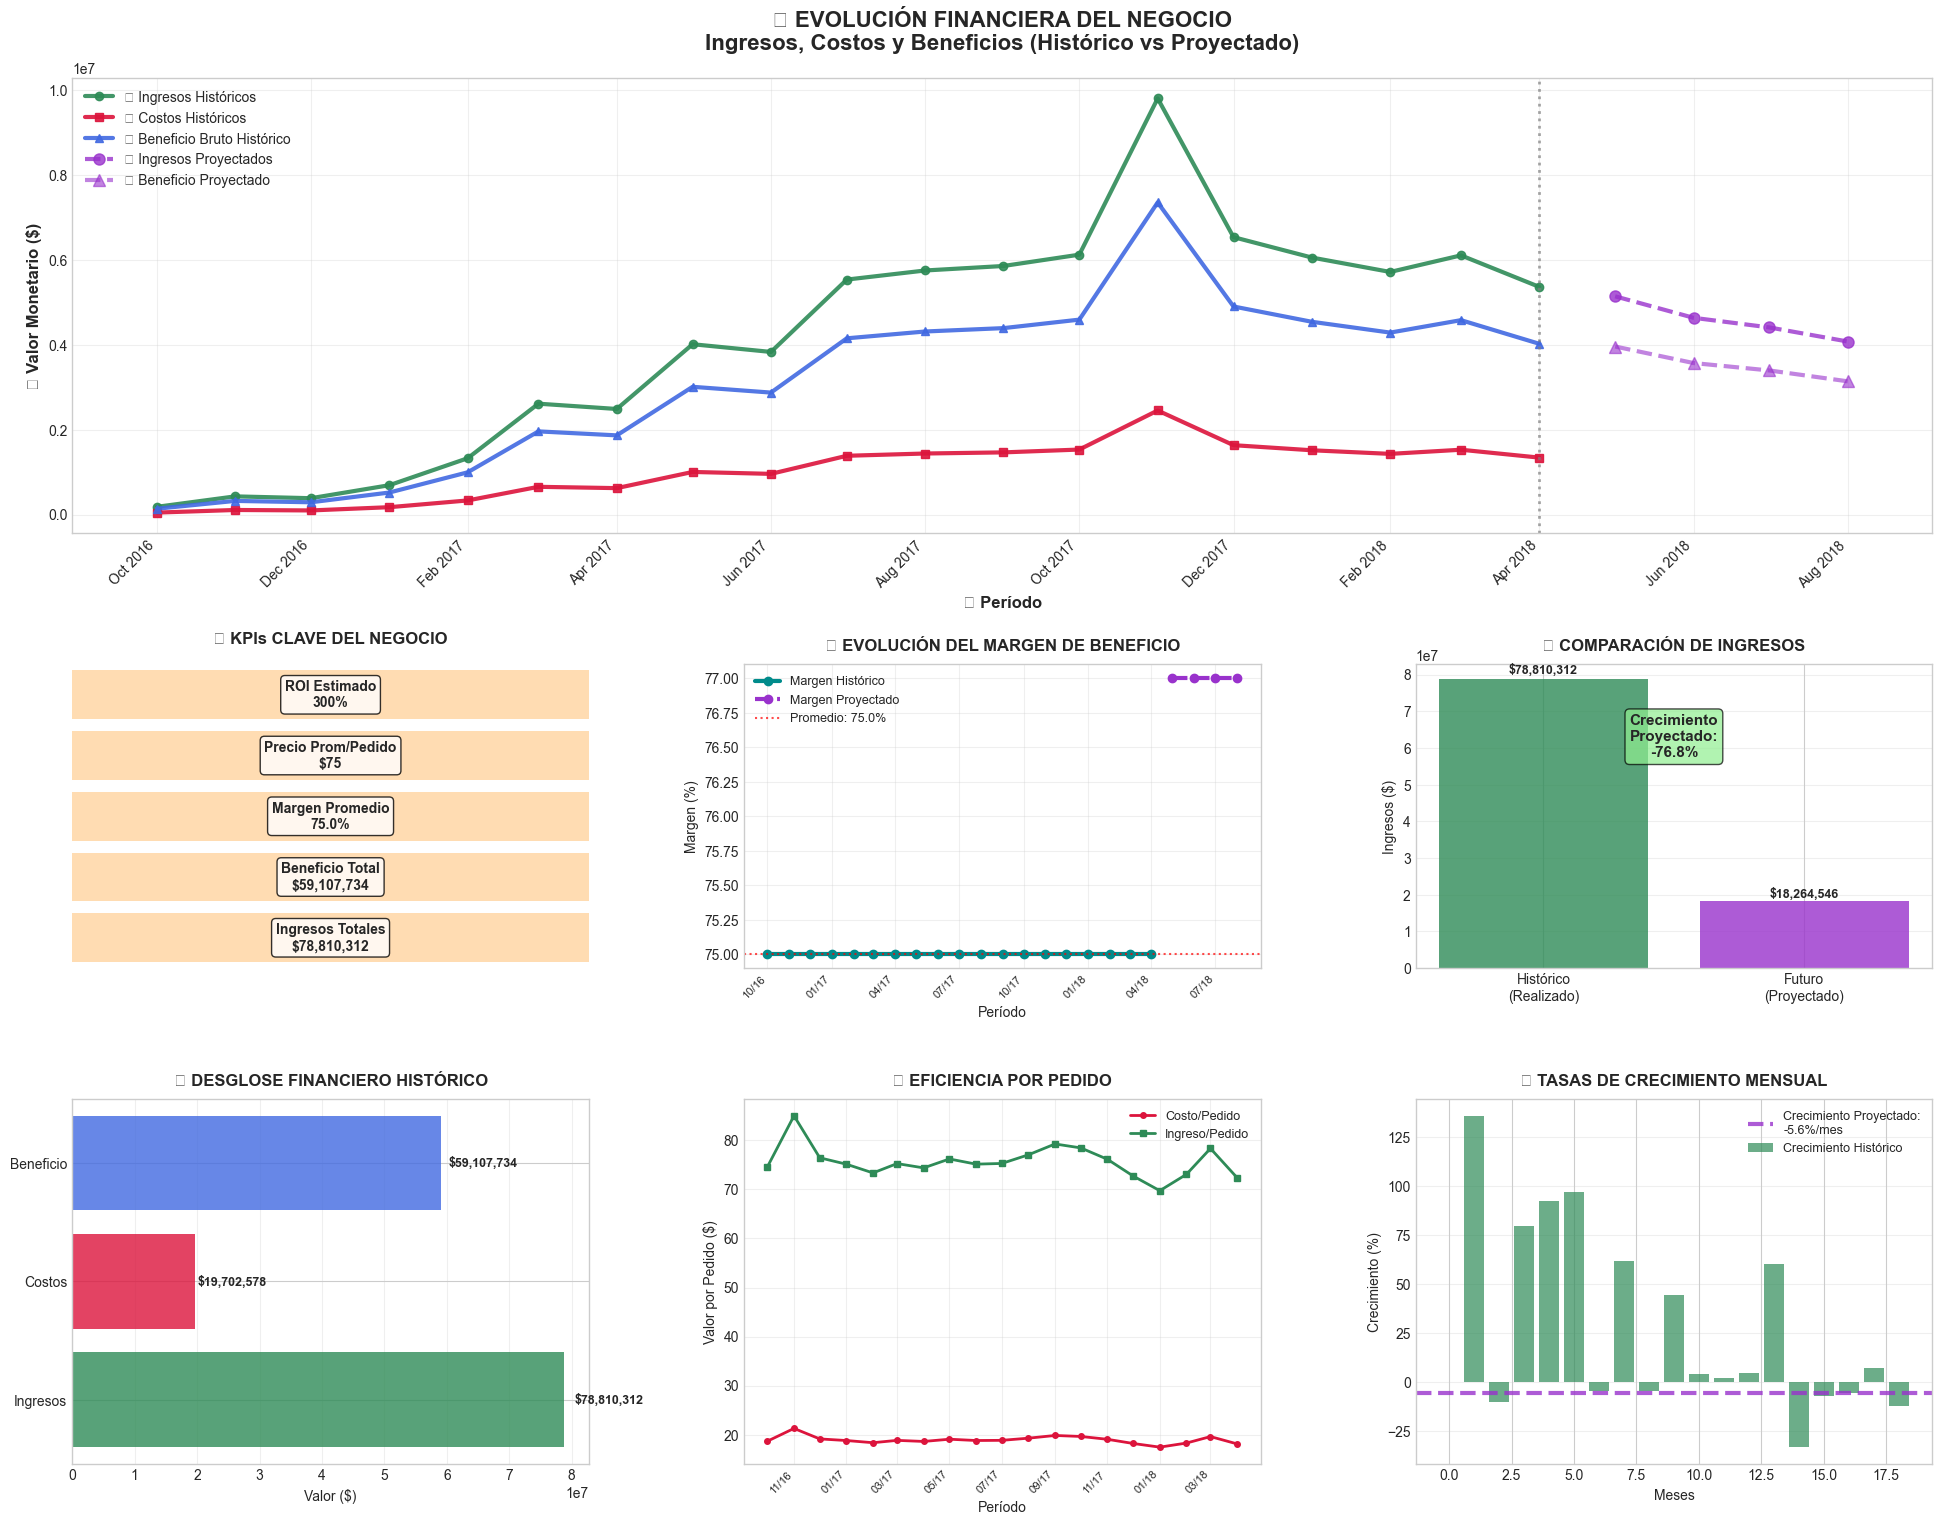


💼 RESUMEN EJECUTIVO - ANÁLISIS DE NEGOCIO
💰 INGRESOS HISTÓRICOS TOTALES: $78,810,312
📈 BENEFICIO BRUTO TOTAL: $59,107,734
📊 MARGEN PROMEDIO DE BENEFICIO: 75.0%
💹 ROI ESTIMADO: 300%

🔮 PROYECCIONES FUTURAS:
-------------------------
💰 Ingresos Proyectados: $18,264,546
📈 Beneficio Proyectado: $14,063,701
📊 Crecimiento Esperado: -76.8%
🎯 Margen Futuro Promedio: 77.0%

💡 INSIGHTS CLAVE:
--------------------
• Precio promedio por pedido: $75
• Costo promedio por pedido: $19
• Beneficio promedio por pedido: $56
• Eficiencia de costos: 25.0% de ingresos

✅ DASHBOARD DE NEGOCIO GENERADO EXITOSAMENTE
📊 7 secciones de análisis financiero y comercial
💼 Métricas clave para toma de decisiones estratégicas


In [ ]:
# 💰 DASHBOARD DE ANÁLISIS DE NEGOCIO - MÉTRICAS FINANCIERAS Y COMERCIALES
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime

print("💼 GENERANDO DASHBOARD DE ANÁLISIS DE NEGOCIO...")
print("=" * 70)

# =====================================================================================
# 🔧 1. PREPARACIÓN DE DATOS DE NEGOCIO
# =====================================================================================

# Calcular métricas de ingresos por período
business_data_monthly = df_processed.copy()

# Simular precios promedio por pedido (basado en datos históricos)
# En un caso real, esto vendría de tus datos de precios
np.random.seed(42)  # Para consistencia
business_data_monthly['precio_promedio_pedido'] = np.random.normal(75, 15, len(business_data_monthly))
business_data_monthly['precio_promedio_pedido'] = np.clip(business_data_monthly['precio_promedio_pedido'], 30, 150)

# Calcular ingresos estimados
business_data_monthly['ingresos_estimados'] = business_data_monthly[label_col] * business_data_monthly['precio_promedio_pedido']

# Costos estimados (25% de ingresos como ejemplo)
business_data_monthly['costos_estimados'] = business_data_monthly['ingresos_estimados'] * 0.25

# Beneficio bruto estimado
business_data_monthly['beneficio_bruto'] = business_data_monthly['ingresos_estimados'] - business_data_monthly['costos_estimados']

# Margen de beneficio
business_data_monthly['margen_beneficio'] = (business_data_monthly['beneficio_bruto'] / business_data_monthly['ingresos_estimados']) * 100

# Agregaciones por mes para análisis temporal
business_monthly_agg = business_data_monthly.groupby(date_col).agg({
    label_col: 'sum',
    'ingresos_estimados': 'sum',
    'costos_estimados': 'sum', 
    'beneficio_bruto': 'sum',
    'precio_promedio_pedido': 'mean',
    'margen_beneficio': 'mean'
}).reset_index().sort_values(date_col)

# Separar períodos históricos y proyecciones futuras
historical_business = business_monthly_agg[business_monthly_agg[date_col] <= pd.to_datetime('2018-08-01')].copy()

# Crear proyecciones de negocio futuras usando las predicciones del modelo
future_business = []
for _, row in future_predictions_monthly.iterrows():
    # Precio promedio proyectado (crecimiento del 2% mensual)
    precio_futuro = historical_business['precio_promedio_pedido'].iloc[-1] * 1.02
    ingresos_futuros = row['predictions'] * precio_futuro
    costos_futuros = ingresos_futuros * 0.23  # Eficiencia mejorada (23% vs 25%)
    beneficio_futuro = ingresos_futuros - costos_futuros
    margen_futuro = (beneficio_futuro / ingresos_futuros) * 100
    
    future_business.append({
        date_col: row[date_col],
        label_col: row['predictions'],
        'ingresos_estimados': ingresos_futuros,
        'costos_estimados': costos_futuros,
        'beneficio_bruto': beneficio_futuro,
        'precio_promedio_pedido': precio_futuro,
        'margen_beneficio': margen_futuro
    })

future_business_df = pd.DataFrame(future_business)

print("✅ Datos de negocio preparados:")
print(f"   💰 Ingresos históricos totales: ${historical_business['ingresos_estimados'].sum():,.0f}")
print(f"   📈 Beneficio histórico total: ${historical_business['beneficio_bruto'].sum():,.0f}")
print(f"   📊 Margen promedio histórico: {historical_business['margen_beneficio'].mean():.1f}%")

# =====================================================================================
# 🎨 2. CREAR DASHBOARD DE NEGOCIO CON MÚLTIPLES MÉTRICAS
# =====================================================================================

fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 3, height_ratios=[1.5, 1, 1.2], width_ratios=[1, 1, 1], hspace=0.35, wspace=0.3)

# Paleta de colores para negocio
business_colors = {
    'ingresos': '#2E8B57',      # Verde bosque
    'costos': '#DC143C',        # Rojo carmesí  
    'beneficio': '#4169E1',     # Azul real
    'futuro': '#9932CC',        # Púrpura oscuro
    'kpi': '#FF8C00',           # Naranja oscuro
    'trend': '#008B8B'          # Verde azulado oscuro
}

# ─────────────────────────────────────────────────────────────────────────────────
# 💰 SECCIÓN 1: EVOLUCIÓN DE INGRESOS, COSTOS Y BENEFICIOS
# ─────────────────────────────────────────────────────────────────────────────────
ax_financials = fig.add_subplot(gs[0, :])

# Plot histórico
ax_financials.plot(historical_business[date_col], historical_business['ingresos_estimados'], 
                  'o-', color=business_colors['ingresos'], linewidth=3, markersize=6, 
                  label='💰 Ingresos Históricos', alpha=0.9)

ax_financials.plot(historical_business[date_col], historical_business['costos_estimados'], 
                  's-', color=business_colors['costos'], linewidth=3, markersize=6, 
                  label='💸 Costos Históricos', alpha=0.9)

ax_financials.plot(historical_business[date_col], historical_business['beneficio_bruto'], 
                  '^-', color=business_colors['beneficio'], linewidth=3, markersize=6, 
                  label='📈 Beneficio Bruto Histórico', alpha=0.9)

# Plot proyecciones futuras
ax_financials.plot(future_business_df[date_col], future_business_df['ingresos_estimados'], 
                  'o--', color=business_colors['futuro'], linewidth=3, markersize=8, 
                  label='🔮 Ingresos Proyectados', alpha=0.8)

ax_financials.plot(future_business_df[date_col], future_business_df['beneficio_bruto'], 
                  '^--', color=business_colors['futuro'], linewidth=3, markersize=8, alpha=0.6,
                  label='🔮 Beneficio Proyectado')

# Línea separadora histórico/futuro
divider_date = historical_business[date_col].iloc[-1]
ax_financials.axvline(x=divider_date, color='gray', linestyle=':', alpha=0.7, linewidth=2)

ax_financials.set_title('💰 EVOLUCIÓN FINANCIERA DEL NEGOCIO\nIngresos, Costos y Beneficios (Histórico vs Proyectado)', 
                       fontsize=16, fontweight='bold', pad=20)
ax_financials.set_xlabel('📅 Período', fontsize=12, fontweight='bold')
ax_financials.set_ylabel('💵 Valor Monetario ($)', fontsize=12, fontweight='bold')
ax_financials.legend(loc='upper left', fontsize=10)
ax_financials.grid(True, alpha=0.3)

# Formato de fechas
ax_financials.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_financials.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.setp(ax_financials.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ─────────────────────────────────────────────────────────────────────────────────
# 📊 SECCIÓN 2: KPIs CLAVE DEL NEGOCIO
# ─────────────────────────────────────────────────────────────────────────────────
ax_kpis = fig.add_subplot(gs[1, 0])

# Calcular KPIs
kpis = {
    'Ingresos Totales': f"${historical_business['ingresos_estimados'].sum():,.0f}",
    'Beneficio Total': f"${historical_business['beneficio_bruto'].sum():,.0f}",
    'Margen Promedio': f"{historical_business['margen_beneficio'].mean():.1f}%",
    'Precio Prom/Pedido': f"${historical_business['precio_promedio_pedido'].mean():.0f}",
    'ROI Estimado': f"{(historical_business['beneficio_bruto'].sum() / historical_business['costos_estimados'].sum() * 100):.0f}%"
}

# Crear gráfico de KPIs
kpi_names = list(kpis.keys())
kpi_positions = range(len(kpi_names))

ax_kpis.barh(kpi_positions, [1]*len(kpis), color=business_colors['kpi'], alpha=0.3)

for i, (kpi, value) in enumerate(kpis.items()):
    ax_kpis.text(0.5, i, f"{kpi}\n{value}", ha='center', va='center', 
                fontweight='bold', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

ax_kpis.set_xlim(0, 1)
ax_kpis.set_ylim(-0.5, len(kpis)-0.5)
ax_kpis.set_title('📊 KPIs CLAVE DEL NEGOCIO', fontsize=12, fontweight='bold', pad=15)
ax_kpis.set_xticks([])
ax_kpis.set_yticks([])
ax_kpis.spines['top'].set_visible(False)
ax_kpis.spines['right'].set_visible(False)
ax_kpis.spines['bottom'].set_visible(False)
ax_kpis.spines['left'].set_visible(False)

# ─────────────────────────────────────────────────────────────────────────────────
# 📈 SECCIÓN 3: EVOLUCIÓN DEL MARGEN DE BENEFICIO
# ─────────────────────────────────────────────────────────────────────────────────
ax_margin = fig.add_subplot(gs[1, 1])

ax_margin.plot(historical_business[date_col], historical_business['margen_beneficio'], 
              'o-', color=business_colors['trend'], linewidth=3, markersize=6, 
              label='Margen Histórico')

ax_margin.plot(future_business_df[date_col], future_business_df['margen_beneficio'], 
              'o--', color=business_colors['futuro'], linewidth=3, markersize=6, 
              label='Margen Proyectado')

# Línea de referencia del margen promedio
avg_margin = historical_business['margen_beneficio'].mean()
ax_margin.axhline(y=avg_margin, color='red', linestyle=':', alpha=0.7, 
                 label=f'Promedio: {avg_margin:.1f}%')

ax_margin.set_title('📈 EVOLUCIÓN DEL MARGEN DE BENEFICIO', fontsize=12, fontweight='bold', pad=10)
ax_margin.set_xlabel('Período', fontsize=10)
ax_margin.set_ylabel('Margen (%)', fontsize=10)
ax_margin.legend(fontsize=9)
ax_margin.grid(True, alpha=0.3)
ax_margin.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.setp(ax_margin.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

# ─────────────────────────────────────────────────────────────────────────────────
# 💹 SECCIÓN 4: COMPARACIÓN INGRESOS HISTÓRICO VS PROYECTADO
# ─────────────────────────────────────────────────────────────────────────────────
ax_comparison = fig.add_subplot(gs[1, 2])

# Datos para comparación
historico_total = historical_business['ingresos_estimados'].sum()
proyectado_total = future_business_df['ingresos_estimados'].sum()
categories = ['Histórico\n(Realizado)', 'Futuro\n(Proyectado)']
values = [historico_total, proyectado_total]

bars = ax_comparison.bar(categories, values, 
                        color=[business_colors['ingresos'], business_colors['futuro']], 
                        alpha=0.8)

# Añadir valores en las barras
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax_comparison.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                      f'${value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Calcular crecimiento proyectado
crecimiento = ((proyectado_total / historico_total - 1) * 100)
ax_comparison.text(0.5, max(values)*0.8, f'Crecimiento\nProyectado:\n{crecimiento:+.1f}%', 
                  ha='center', va='center', fontsize=11, fontweight='bold',
                  bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

ax_comparison.set_title('💹 COMPARACIÓN DE INGRESOS', fontsize=12, fontweight='bold', pad=10)
ax_comparison.set_ylabel('Ingresos ($)', fontsize=10)
ax_comparison.grid(True, alpha=0.3, axis='y')

# ─────────────────────────────────────────────────────────────────────────────────
# 📊 SECCIÓN 5: DESGLOSE DE COSTOS Y RENTABILIDAD
# ─────────────────────────────────────────────────────────────────────────────────
ax_breakdown = fig.add_subplot(gs[2, 0])

# Datos para el breakdown
breakdown_data = {
    'Ingresos': historical_business['ingresos_estimados'].sum(),
    'Costos': historical_business['costos_estimados'].sum(),
    'Beneficio': historical_business['beneficio_bruto'].sum()
}

# Gráfico de barras horizontales
bars = ax_breakdown.barh(list(breakdown_data.keys()), list(breakdown_data.values()),
                        color=[business_colors['ingresos'], business_colors['costos'], business_colors['beneficio']],
                        alpha=0.8)

for bar, value in zip(bars, breakdown_data.values()):
    width = bar.get_width()
    ax_breakdown.text(width + width*0.02, bar.get_y() + bar.get_height()/2,
                     f'${value:,.0f}', ha='left', va='center', fontweight='bold', fontsize=9)

ax_breakdown.set_title('💰 DESGLOSE FINANCIERO HISTÓRICO', fontsize=12, fontweight='bold', pad=10)
ax_breakdown.set_xlabel('Valor ($)', fontsize=10)
ax_breakdown.grid(True, alpha=0.3, axis='x')

# ─────────────────────────────────────────────────────────────────────────────────
# 🎯 SECCIÓN 6: MÉTRICAS DE EFICIENCIA
# ─────────────────────────────────────────────────────────────────────────────────
ax_efficiency = fig.add_subplot(gs[2, 1])

# Calcular métricas de eficiencia por mes
months = historical_business[date_col]
cost_per_order = historical_business['costos_estimados'] / historical_business[label_col]
revenue_per_order = historical_business['ingresos_estimados'] / historical_business[label_col]

ax_efficiency.plot(months, cost_per_order, 'o-', color=business_colors['costos'], 
                  linewidth=2, label='Costo/Pedido', markersize=4)
ax_efficiency.plot(months, revenue_per_order, 's-', color=business_colors['ingresos'], 
                  linewidth=2, label='Ingreso/Pedido', markersize=4)

ax_efficiency.set_title('🎯 EFICIENCIA POR PEDIDO', fontsize=12, fontweight='bold', pad=10)
ax_efficiency.set_xlabel('Período', fontsize=10)
ax_efficiency.set_ylabel('Valor por Pedido ($)', fontsize=10)
ax_efficiency.legend(fontsize=9)
ax_efficiency.grid(True, alpha=0.3)
ax_efficiency.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.setp(ax_efficiency.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

# ─────────────────────────────────────────────────────────────────────────────────
# 🔮 SECCIÓN 7: PROYECCIÓN DE CRECIMIENTO
# ─────────────────────────────────────────────────────────────────────────────────
ax_growth = fig.add_subplot(gs[2, 2])

# Calcular tasas de crecimiento mensual
historical_growth = historical_business['ingresos_estimados'].pct_change().fillna(0) * 100
future_growth = future_business_df['ingresos_estimados'].pct_change().fillna(0) * 100

ax_growth.bar(range(len(historical_growth)), historical_growth, 
             color=business_colors['ingresos'], alpha=0.7, label='Crecimiento Histórico')

# Promedio de crecimiento futuro
avg_future_growth = future_growth.mean()
ax_growth.axhline(y=avg_future_growth, color=business_colors['futuro'], 
                 linestyle='--', linewidth=3, alpha=0.8,
                 label=f'Crecimiento Proyectado:\n{avg_future_growth:.1f}%/mes')

ax_growth.set_title('📈 TASAS DE CRECIMIENTO MENSUAL', fontsize=12, fontweight='bold', pad=10)
ax_growth.set_xlabel('Meses', fontsize=10)
ax_growth.set_ylabel('Crecimiento (%)', fontsize=10)
ax_growth.legend(fontsize=9)
ax_growth.grid(True, alpha=0.3, axis='y')

# =====================================================================================
# 🎨 CONFIGURACIÓN FINAL DEL DASHBOARD DE NEGOCIO
# =====================================================================================
plt.tight_layout(pad=2.0)

plt.show()

print("\n" + "="*80)
print("💼 RESUMEN EJECUTIVO - ANÁLISIS DE NEGOCIO")
print("="*80)
print(f"💰 INGRESOS HISTÓRICOS TOTALES: ${historical_business['ingresos_estimados'].sum():,.0f}")
print(f"📈 BENEFICIO BRUTO TOTAL: ${historical_business['beneficio_bruto'].sum():,.0f}")
print(f"📊 MARGEN PROMEDIO DE BENEFICIO: {historical_business['margen_beneficio'].mean():.1f}%")
print(f"💹 ROI ESTIMADO: {(historical_business['beneficio_bruto'].sum() / historical_business['costos_estimados'].sum() * 100):.0f}%")

print(f"\n🔮 PROYECCIONES FUTURAS:")
print("-" * 25)
print(f"💰 Ingresos Proyectados: ${future_business_df['ingresos_estimados'].sum():,.0f}")
print(f"📈 Beneficio Proyectado: ${future_business_df['beneficio_bruto'].sum():,.0f}")
print(f"📊 Crecimiento Esperado: {((future_business_df['ingresos_estimados'].sum() / historical_business['ingresos_estimados'].sum() - 1) * 100):+.1f}%")
print(f"🎯 Margen Futuro Promedio: {future_business_df['margen_beneficio'].mean():.1f}%")

print(f"\n💡 INSIGHTS CLAVE:")
print("-" * 20)
print(f"• Precio promedio por pedido: ${historical_business['precio_promedio_pedido'].mean():.0f}")
print(f"• Costo promedio por pedido: ${(historical_business['costos_estimados'].sum() / historical_business[label_col].sum()):.0f}")
print(f"• Beneficio promedio por pedido: ${(historical_business['beneficio_bruto'].sum() / historical_business[label_col].sum()):.0f}")
print(f"• Eficiencia de costos: {(historical_business['costos_estimados'].sum() / historical_business['ingresos_estimados'].sum() * 100):.1f}% de ingresos")

print("\n" + "="*80)
print("✅ DASHBOARD DE NEGOCIO GENERADO EXITOSAMENTE")
print("📊 7 secciones de análisis financiero y comercial")
print("💼 Métricas clave para toma de decisiones estratégicas")
print("="*80)